# Hoja de problemas 2

* Student 1: Gorka Crespo Bravo
* Student 2: Miguel Cuesta Altable
* Student 3: Antón Salvadores Muñiz

In [ ]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 14.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arch

from scipy import stats
from scipy.stats import norm, lognorm, t, chi2, skew, kurtosis
from scipy.optimize import minimize

import statsmodels.api as sm
import statsmodels.graphics.tsaplots as sgt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf, adfuller, acovf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.sandwich_covariance import cov_hac_simple
from statsmodels.tsa.api import VAR
from arch import arch_model
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression


from arch.univariate import ConstantMean, GARCH, Normal, StudentsT

from HW02_Econometría_functions import (
    fit_AR_GARCH_ML_gaussian_noise_SLSQP,
    residuals_ARMA_GARCH,
    fit_AR_GARCH_ML_student_t_noise_SLSQP,
    fit_AR_GARCH_M_ML_gaussian_noise_SLSQP,
    residuals_ARMA_GARCH_M,
    fit_AR_EGARCH_ML_gaussian_noise_SLSQP,
    residuals_ARMA_EGARCH,
    fit_AR_TGARCH_ML_gaussian_noise_SLSQP,
    residuals_ARMA_TGARCH,
    gfevd,
    lfv_DCC,
    dynamic_hedge_ratio_MS
)


/content/HW02_Econometría_functions.py:795: SyntaxWarning: invalid escape sequence '\s'
  ax.plot(true_vol, label='Varianza Real ($\sigma^2_t$)', color='blue', alpha=0.5)
/content/HW02_Econometría_functions.py:796: SyntaxWarning: invalid escape sequence '\h'
  ax.plot(est_vol, label='Varianza Estimada ($\hat{\sigma}^2_t$)', color='red', linestyle='--')


# Ejercicio 1

Suponga el siguiente proceso generador de datos para la matriz $y_t$:

$$
T = 500. \\
y_t = \mu + e_t, \quad \mu = 0.01 \\
V(e_t) = \sigma^2_t, \,\, \text{tal que} \begin{cases} \sigma^2_t = \sigma^2_{t-1} \, \, \text{con prob.} \quad \phi=0.96 \\
\sigma^2_t = a_t \quad \, \text{con prob.} \quad 1 - \phi=0.04
\end{cases} \\
$$
donde $a_t$ sigue una distribución $\Gamma(a,b) = \Gamma(4,0.2)$.

El siguiente código genera esos datos simulados para $y_t$ (transcritos a Python, en el enunciado original están en MatLab).

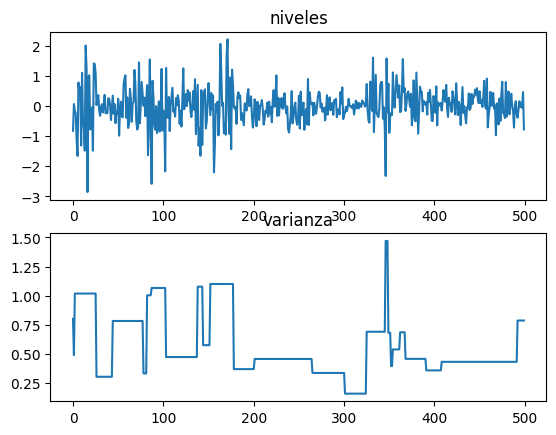

In [ ]:
T = 500
mu = 0.01
phi = 0.96
a = 4
b = 0.2

vsigma2t = []
vyt = []

sigma2t0 = a * b

for t in range(T):
    u = np.random.rand()
    if u < phi:
        sigma2t = sigma2t0
        yt = mu + sigma2t * np.random.randn()
        vsigma2t.append(sigma2t)
        vyt.append(yt)
        sigma2t0 = sigma2t
    else:
        sigma2t = stats.gamma(a, scale=b).rvs()
        yt = mu + sigma2t * np.random.randn()
        vsigma2t.append(sigma2t)
        vyt.append(yt)
        sigma2t0 = sigma2t

plt.figure()
plt.subplot(2,1,1)
plt.plot(vyt)
plt.title('niveles')

plt.subplot(2,1,2)
plt.plot(vsigma2t)
plt.title('varianza')

plt.show()


Construya diferentes modelos GARCH y compare las estimaciones obtenidas de la serie de volatilidades estimada con cada uno de los modelos GARCH utilizados. Los modelos GARCH pueden ser: GARCH$(1,1)$, EGARCH$(1,1)$, GARCH-M$(1,1)$, GARCH$(1,1)$ con innovaciones $t$ de $Student$, y TGARCH. Compare los Criterios de Información Akaike ($AIC$) y $BIC$ (Bayesian Information Criteria) también entre los distintos modelos. Use el “comando” de MatLab: aicbic (en Python, tras ajustar el modelo nombrado "model" por ejemplo, usar el comando model.aic para el $AIC$ y el comando model.bic para el $BIC$, del paquete _statsmodel_).

Se trata de usar unos datos generados con alguna característica de las series financieras (datos con rachas aleatorias de volatilidades altas y bajas), pero no generados por algún modelo GARCH específico. De esta forma pueden compararse de una forma “justa” el comportamiento de diferentes modelos GARCH.

**RESOLUCIÓN DEL EJERCICIO**

Tal y como está construido el proceso $y_t$, como se puede observar en los gráficos, tenemos periodos de volatilidad más alta y periodos de volatilidad más baja. Este fenómeno se llama clúster de volatilidad. En concreto, debido a la construcción de los datos, la varianza es un proceso con saltos, donde se mantiene en un nivel constante antes de un salto.

Los modelos GARCH suponen en primer lugar que el proceso a estudiar (en este caso, $y_t$), sigue un modelo de series temporales univariantes:
$$
y_t = \mu_t + a_t \, , \\
$$
donde $\mu_t$ representa la ecuación para la media del proceso y $a_t$ representa la innovación o shock del proceso en el momento $t$.

Los modelos GARCH tratan de modelizar una ecuación para la volatilidad del proceso, i.e, tratan de modelizar el shock $a_t$ (salvo el GARCH-M($1,1$), que sí que modifica ligeramente $\mu_t$). Estos modelos tratan de explicar las agrupaciones de volatilidad que se observan en las series financieras, precisamente lo que sucede en el proceso que hemos generado, el clúster de volatilidad.

En concreto, todos los modelos propuestos suponen la siguiente ecuación para $a_t$:
$$
a_t = \sigma_t \epsilon_t \, , \\
$$
donde cada modelo propone una ecuación para la volatilidad condicional ($\sigma_t$) suponiendo algún tipo de distribución para las innovaciones $\epsilon_t$ (normal, $t$ de $Student$,...). Con estos supuestos, nuestro modelo general para los datos sería el siguiente:
$$
y_t = \mu_t + a_t = \mu_t + \sigma_t \epsilon_t \, ,
$$
y trataremos de ajustar una ecuación para $\sigma^2_t$ en cada caso. En el caso del GARCH-M($1,1$), tendremos que reformular la ecuación para la media $\mu_t$ también, en los demás modelos $\mu_t = \mu$, que será un parámetro a estimar también, aunque conocemos de antemano que debería ser igual a $0.01$ (estadísticamente insignificante e igual a $0$).

Realizaremos la estimación de los modelos maximizando la función de verosimilitud $\mathcal{L}$ (minimizando $-\log\mathcal{L}$ realmente, ya que son equivalentes y la optativa óptima computacionalmente es esta última).



**Modelo para GARCH(1,1) con innovaciones normales:**



El GARCH(1,1) con innovaciones normales supone:

$$
y_t = \mu_t + a_t \\
\mu_t = \mu \\
a_t = \sigma_t \epsilon_t \\
\epsilon_t \underset{iid}\sim N(0, 1) \\
\sigma^2_t = \alpha_0 + \alpha_1 a^2_{t-1} + \beta_1 \sigma^2_{t-1} \, , \\
\alpha_0 > 0 \, , 0 \leq \alpha_1, \beta_1 \leq 1 \, , \alpha_1+ \beta_1 \leq 1.
$$

Estas restricciones sobre los coeficientes son necesarias para que el proceso tenga varianza positiva y sea estacionario.

Para la estimación del modelo, primero nos damos cuenta de lo siguiente:

$$
\mathbb{E}_{t-1}(a_t) = \mathbb{E}_{t-1}(\sigma_t \epsilon_t) = \sigma_t\mathbb{E}_{t-1}(\epsilon_t) = 0 \\
\mathbb{V}_{t-1}(a_t) = \mathbb{E}_{t-1}(a^2_t) = \mathbb{E}_{t-1}(\sigma^2_t\epsilon^2_t) = \sigma^2_t\mathbb{E}_{t-1}(\epsilon^2_t) = \sigma^2_t. \\
$$
Por tanto, se tiene que la distribución condicional de $a_t|\Omega_{t-1} \sim N(0,\sigma^2_t)$.

Ahora, para calcular la función de verosimilitud, tenemos lo siguiente, donde $f$ denotará la función de densidad de $a_t$ (que sabemos que será una normal de media $0$ y varianza $\sigma^2_t$):

$$
\mathcal{L}(a_1, \ldots, a_T | \alpha_0, \alpha_1, \beta_1) = f(a_T | \Omega_{T-1}) \cdots f(a_2 | \Omega_1) f(a_1 | \alpha_0, \alpha_1, \beta_1)
$$

En general, la forma explícita de $f(a_1 | \alpha_0, \alpha_1, \beta_1)$ es complicada y se suele eliminar de la verosimilitud ya que no influye demasiado en la estimación de los parámetros, sobretodo si la muestra es grande (en nuestro caso, $T=500$ así que está más que justificado). Así, nuestra función de verosimilitud es la siguiente:

$$
\mathcal{L}(a_1, \ldots, a_T | \alpha_0, \alpha_1, \beta_1) = \prod_{t=2}^T \frac{1}{\sqrt{2\pi\sigma^2_t}} \exp\left[-\frac{1}{2}\left(\frac{a_t}{\sigma_t}\right)^2\right]
$$

Dado que $\sigma^2_2 = \alpha_0 + \alpha_1 a^2_{1} + \beta_1 \sigma^2_{1}$, necesitamos un valor inicial de $\sigma^2_1$. Utilizaremos el siguiente ya que se corresponde con la varianza a largo plazo y además, así en el proceso de optimización de los parámetros este valor es recalculado constantemente para obtener la mejor estimación posible $\sigma^2_1 = \frac{\alpha_0}{1-\alpha_1-\beta_1}$.

In [ ]:
vyt = np.array(vyt)
mu_ML, phi_ML, alpha_0_ML, alpha_ML, beta_ML, info_optimization = fit_AR_GARCH_ML_gaussian_noise_SLSQP(
    vyt,
    phi_0_seed=mu,
    phi_seed=[],
    kappa_seed=0.1,
    alpha_seed=[0.1],
    beta_seed=[0.8],
)

/content/HW02_Econometría_functions.py:237: OptimizeWarning: Unknown solver options: xatol
  info_optimization = minimize(
/content/HW02_Econometría_functions.py:200: RuntimeWarning: invalid value encountered in sqrt
  norm.logpdf(u, loc=0.0, scale=np.sqrt(h))
/content/HW02_Econometría_functions.py:278: RuntimeWarning: divide by zero encountered in scalar divide
  h[:, :delay] = kappa / (1.0 - np.sum(alpha) - np.sum(beta))


In [ ]:
results_data = {
    'Parámetro': ['mu', 'alpha_0', 'alpha_1', 'beta_1'],
    'Estimación': [
        mu_ML,
        alpha_0_ML,
        float(alpha_ML[0]) if np.ndim(alpha_ML) > 0 else alpha_ML,
        float(beta_ML[0]) if np.ndim(beta_ML) > 0 else beta_ML
    ]
}
df_resultados = pd.DataFrame(results_data)
df_resultados.set_index('Parámetro', inplace=True)
print("Resultados de la Estimación (Maximum Likelihood):")
display(df_resultados.style.format("{:.6f}"))
print("\n--- Info Optimización ---")
print(f"Éxito: {info_optimization.success}")
print(f"Mensaje: {info_optimization.message}")
print(f"Iteraciones: {info_optimization.nit}")
print(f"Log-Verosimilitud Negativa Final: {info_optimization.fun:.4f}")

Resultados de la Estimación (Maximum Likelihood):


,Estimación
Parámetro,
mu,0.003970
alpha_0,0.009716
alpha_1,0.174673
beta_1,0.813054



--- Info Optimización ---
Éxito: True
Mensaje: Optimization terminated successfully
Iteraciones: 35
Log-Verosimilitud Negativa Final: 394.6239


In [ ]:
a_data = vyt - mu
a_ML, sigma2_ML = residuals_ARMA_GARCH(
    vyt,
    mu_ML,
    phi_ML,
    [],
    alpha_0_ML,
    alpha_ML,
    beta_ML
)

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\h'
<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\h'
<>:6: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-1959313383.py:2: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(vsigma2t, label='$\sigma_t^2$', color='blue', alpha=0.7)
/tmp/ipython-input-1959313383.py:3: SyntaxWarning: invalid escape sequence '\h'
  plt.plot(sigma2_ML, label='$\hat{\sigma}_t^2$', color='red', linestyle='--')
/tmp/ipython-input-1959313383.py:6: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('Varianza ($\sigma_t^2$)')


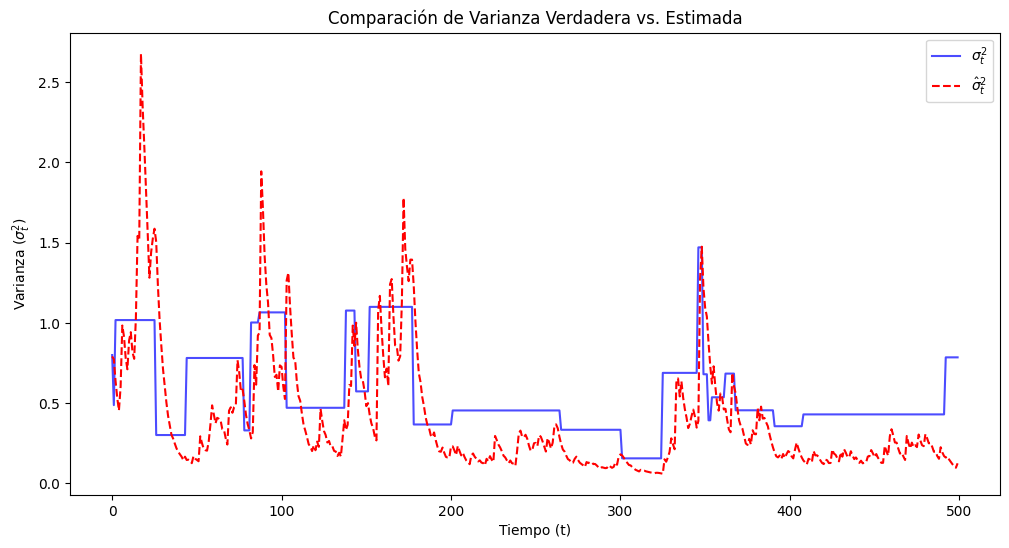

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(vsigma2t, label='$\sigma_t^2$', color='blue', alpha=0.7)
plt.plot(sigma2_ML, label='$\hat{\sigma}_t^2$', color='red', linestyle='--')
plt.title('Comparación de Varianza Verdadera vs. Estimada')
plt.xlabel('Tiempo (t)')
plt.ylabel('Varianza ($\sigma_t^2$)')
plt.legend()
plt.show()

<>:3: SyntaxWarning: invalid escape sequence '\h'
<>:3: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipython-input-2574542121.py:3: SyntaxWarning: invalid escape sequence '\h'
  plt.plot(a_ML, label='$\hat{a}_t$', color='red', linestyle='--')


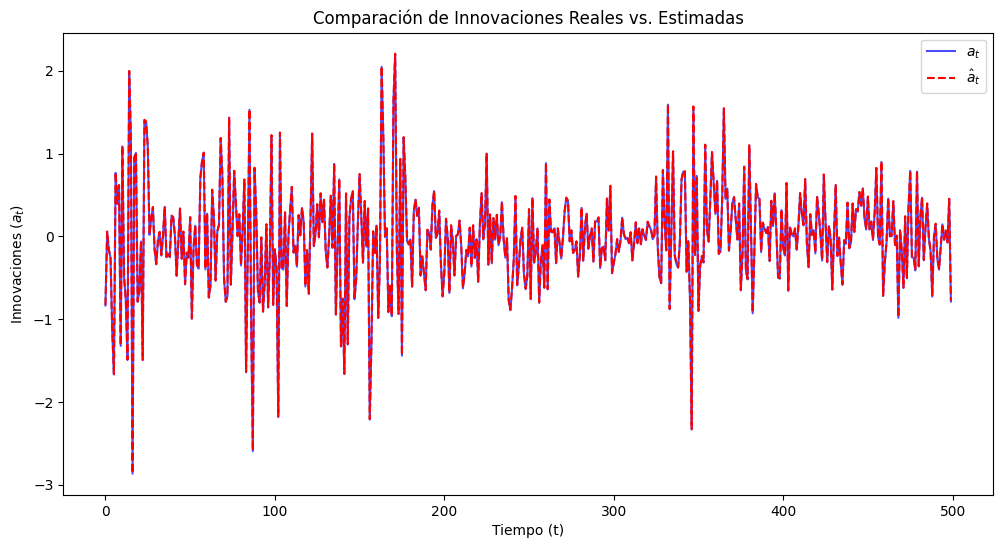

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(a_data, label='$a_t$', color='blue', alpha=0.7)
plt.plot(a_ML, label='$\hat{a}_t$', color='red', linestyle='--')
plt.title('Comparación de Innovaciones Reales vs. Estimadas')
plt.xlabel('Tiempo (t)')
plt.ylabel('Innovaciones ($a_t$)')
plt.legend()
plt.show()

<>:3: SyntaxWarning: invalid escape sequence '\h'
<>:3: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipython-input-3790616760.py:3: SyntaxWarning: invalid escape sequence '\h'
  plt.plot(a_ML + mu, label='$\hat{y}_t$', color='red', linestyle='--')


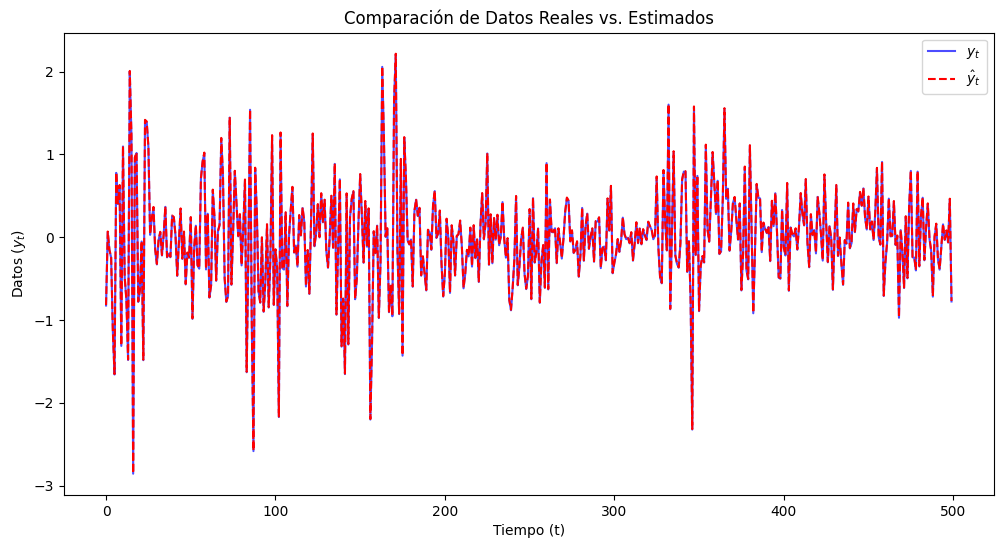

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(vyt, label='$y_t$', color='blue', alpha=0.7)
plt.plot(a_ML + mu, label='$\hat{y}_t$', color='red', linestyle='--')
plt.title('Comparación de Datos Reales vs. Estimados')
plt.xlabel('Tiempo (t)')
plt.ylabel('Datos ($y_t$)')
plt.legend()
plt.show()

Tras la estimación del modelo, obtenemos el siguiente modelo estimado:

$$
y_t = \mu^{ML} + a_t, \\
a_t = \sigma_t \epsilon_t \\
\sigma^2_t = \alpha^{ML}_0 + \alpha^{ML}_1 a^2_{t-1} + \beta^{ML}_1 \sigma^2_{t-1} \,\, ; \,\, t = 2,\ldots, T \\
\sigma^2_1 = \frac{\alpha^{ML}_0}{1 - \alpha^{ML}_1 - \beta^{ML}_1} \,\,
$$

(_No incluimos los datos reales ya que a cada simulación que hagamos de los datos, saldrán estimaciones diferentes. Si se desea ver qué valor tienen los parámetros en esta simulación particular, véase la tabla superior. Esto aplica para todos los GARCH simulados_.) En comparación con el proceso generado:

$$
y_t = 0.01 + e_t,  \\
V(e_t) = \sigma^2_t, \,\, \text{tal que} \begin{cases} \sigma^2_t = \sigma^2_{t-1} \, \, \text{con prob.} \quad \phi=0.96 \\
\sigma^2_t = a_t \quad \, \text{con prob.} \quad 1 - \phi=0.04
\end{cases} \\
$$
donde $a_t$ sigue una distribución $\Gamma(a,b) = \Gamma(4,0.2)$.

Podemos observar que en nuestra estimación del GARCH($1,1$) el parámetro de la persistencia es más alto que el de la reacción ante nuevos shocks, algo que se asemeja con el proceso generador de datos ya que con una muy alta probabilidad la varianza de hoy es igual a la varianza de ayer. Además, observando el gráfico de la varianza estimada y la varianza real, el modelo parece que se ajusta relativamente bien. Uno podría pensar que la deriva del proceso generador de datos está mal estimada, la realidad es que ambos datos son estadísticamente insignificantes, como se puede comprobar en los gráficos de comparativa entre $a_t$ y $\hat{a}_t$ y entre $y_t$ y $\hat{y}_t$, ya que son prácticamente idénticos, salvo esa diferencia entre la media real y estimada que es ínfima, del orden de $10^{-2}$.

Volviendo al gráfico relevante, donde se compara la varianza real y estimada, la varianza real es generada por un proceso con saltos con una probabilidad cercana a uno de que la varianza del día de hoy sea igual a la del día anterior y se produce un salto cuando cambia la varianza. Este efecto está captado en buena medida por el GARCH($1,1$) con innovaciones normales, ya que la varianza estimada sube (o baja) en cuanto hay un salto real en la varianza, como es debido, y se mantiene razonablemente bien mientras la varianza se conserva estable. A falta de pruebas estadísticas, parece que estamos ante un buen ajuste.

_Nota_: _El procedimiento de estimación en los demás GARCHs será muy semejante, así que salvo ciertos detalles relevantes, omitiremos algunos pasos y no efectuaremos una demostración tan precisa de los resultados. Asimismo, los gráficos de comparativa entre las innovaciones reales y estimadas, y los datos reales y estimados, no los volveremos a incluir y consideraremos que son prácticamente idénticos en todos los casos._

**Modelo para GARCH(1,1) con innovaciones $t$ de $Student$:**

El GARCH(1,1) con innovaciones $t$ de $Student$ supone:

$$
y_t = \mu_t + a_t \\
\mu_t = \mu
a_t = \sigma_t \epsilon_t \\
x_t \underset{iid}\sim \, t\left(\nu, loc=0, scale=1\right) \,\,;  \mathbb{E}(x_t) = 0 \,\, ; \mathbb{V}(x_t) = \frac{\nu}{\nu-2}\\
\epsilon_t = \frac{x_t}{\sqrt{\frac{\nu}{\nu-2}}} \underset{iid}\sim \, t\left(\nu\right) \,\, ; \mathbb{E}(\epsilon_t) = 0 \,\, ; \mathbb{V}(\epsilon_t) = 1\\
\sigma^2_t = \alpha_0 + \alpha_1 a^2_{t-1} + \beta_1 \sigma^2_{t-1} \, , \\
\alpha_0 > 0 \, , \nu > 2 \, , 0 \leq \alpha_1, \beta_1 \leq 1 \, , \alpha_1+ \beta_1 \leq 1. \\
$$

Estas restricciones sobre los coeficientes son necesarias para que el proceso tenga varianza positiva y sea estacionario. Suponemos que las innovaciones siguen una $t$ de $Student$ estandarizada, esto es, centrada en el $0$ y con volatilidad igual a $1$. Para que estén bien definidos los momentos de orden $n$ de la distribución necesitamos que los grados de libertad ($\nu$) de la distribución sean mayores que el orden del momento que queremos calcular ($\nu > n$). En concreto, para que la varianza esté bien definida, necesitamos $\nu>2$ obligatoriamente. Los valores de $\nu$ pre-especificados varían entre $3$ y $6$ debido a esto. Nosotros permitiremos que nuestro software estime también el parámetro $\nu$ para obtener la mejor estimación posible a los datos.

Para la estimación de este modelo, de nuevo, se tiene que $a_t | \Omega_{t-1} \sim \, t\left(\nu\right) \, ; \mathbb{E}(a_t) = 0 \,\, ; \mathbb{V}(a_t) = \sigma^2_t \,\, ; t = 2, \ldots, T$.

Por un lado, la función de densidad de $x_t$ será:

$$
\text{pdf}(x_t) = \frac{\Gamma(\frac{\nu+1)}{2}}{\sqrt{\nu\pi}\Gamma(\frac{\nu}{2})} \left(1 + \frac{x^2_t}{\nu}\right)^{-\frac{\nu+1}{2}}
$$

Teniendo esto en cuenta, la función de densidad de $\epsilon_t = \frac{x_t}{\sqrt{\frac{\nu}{\nu-2}}}$ es:

$$
\text{pdf}(\epsilon_t) = \frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\sqrt{\nu\pi}\Gamma\left(\frac{\nu}{2}\right)} \left(1 + \frac{\epsilon^2_t{\frac{\nu}{\nu-2}}}{\nu}\right)^{-\frac{\nu+1}{2}} \cdot \sqrt{{\frac{\nu}{\nu-2}}} = \\
= \frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\sqrt{(\nu-2)\pi}\Gamma\left(\frac{\nu}{2}\right)} \left(1 + \frac{\epsilon^2_t}{\nu-2}\right)^{-\frac{\nu+1}{2}}.
$$

Utilizando la misma manera de proceder para el cambio de variable, ahora deducimos la función de densidad de $a_t = \sigma_t\epsilon_t |\Omega_{t-1}$:

$$
\text{pdf}(a_t|\Omega_{t-1}) = \frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\sqrt{\nu\pi}\Gamma\left(\frac{\nu}{2}\right)} \left(1 + \frac{\left(\frac{a_t}{\sigma_t}\right)^2}{\nu-2}\right)^{-\frac{\nu+1}{2}} \cdot {\frac{1}{\sigma_t}} = \\
= \frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\sqrt{(\nu-2)\pi\sigma^2_t}\Gamma\left(\frac{\nu}{2}\right)} \left(1 + \frac{a^2_t}{(\nu-2)\sigma_t^2}\right)^{-\frac{\nu+1}{2}}.
$$

Así, la función de verosimilitud a maximizar será:

$$
\mathcal{L}(a_1, \ldots, a_T | \alpha_0, \nu, \alpha_1, \beta_1) = \prod_{t=2}^T \frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\sqrt{(\nu-2)\pi\sigma^2_t}\Gamma\left(\frac{\nu}{2}\right)} \left(1 + \frac{a^2_t}{(\nu-2)\sigma_t^2}\right)^{-\frac{\nu+1}{2}}
$$

Como minimizaremos el $-\log\mathcal{L}$, equivalentemente se tiene:

$$
-\log\mathcal{L}(a_1, \ldots, a_T | \alpha_0, \nu, \alpha_1, \beta_1) = \\
- \log\left[\prod_{t=2}^T \frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\sqrt{(\nu-2)\pi\sigma^2_t}\Gamma(\frac{\nu}{2})} \left(1 + \frac{a^2_t}{(\nu-2)\sigma_t^2}\right)^{-\frac{\nu+1}{2}}\right] = \\
 -\,(T-1)\,
\Bigl[
  \log\Gamma\!\Bigl(\tfrac{\nu+1}{2}\Bigr)
  -\log\Gamma\!\Bigl(\tfrac{\nu}{2}\Bigr)
  -\tfrac12\log((\nu-2)\pi)
\Bigr] \;
+\;
\sum_{t=2}^T \log\sigma_t
 + \tfrac{\nu+1}{2}\log\!\Bigl(
  1 + \frac{1}{\nu-2}
  \Bigl(\tfrac{a_t}{\sigma_t}\Bigr)^2
\Bigr) \,\,,
$$

que será nuestra función a minimizar. Dado que $\sigma^2_2 = \alpha_0 + \alpha_1 a^2_{1} + \beta_1 \sigma^2_{1}$, necesitamos un valor inicial de $\sigma^2_1$. Utilizaremos el siguiente ya que se corresponde con la varianza a largo plazo y además, así en el proceso de optimización de los parámetros este valor es recalculado constantemente para obtener la mejor estimación posible $\sigma^2_1 = \frac{\alpha_0}{1-\alpha_1-\beta_1}$.


In [ ]:
mu_tML, phi_tML, alpha_0_tML, alpha_tML, beta_tML, nu_ML, info_toptimization = fit_AR_GARCH_ML_student_t_noise_SLSQP(
    vyt,
    phi_0_seed=mu,
    phi_seed=[],
    kappa_seed=0.1,
    alpha_seed=[0.1],
    beta_seed=[0.8],
    nu_seed=10.0
)

/content/HW02_Econometría_functions.py:363: OptimizeWarning: Unknown solver options: xatol
  info_optimization = minimize(
/content/HW02_Econometría_functions.py:331: RuntimeWarning: invalid value encountered in log
  - gammaln(nu / 2) - 0.5 * np.log(h)
/content/HW02_Econometría_functions.py:332: RuntimeWarning: invalid value encountered in log
  - ((nu + 1) / 2) * np.log(1 + (u**2) / ((nu-2) * h))
/content/HW02_Econometría_functions.py:278: RuntimeWarning: divide by zero encountered in scalar divide
  h[:, :delay] = kappa / (1.0 - np.sum(alpha) - np.sum(beta))


In [ ]:
results_data = {
    'Parámetro': ['mu', 'alpha_0', 'alpha_1', 'beta_1', 'nu'],
    'Estimación': [
        mu_tML,
        alpha_0_tML,
        float(alpha_tML[0]) if np.ndim(alpha_tML) > 0 else alpha_tML,
        float(beta_tML[0]) if np.ndim(beta_tML) > 0 else beta_tML,
        nu_ML
    ]
}
df_resultados = pd.DataFrame(results_data)
df_resultados.set_index('Parámetro', inplace=True)
print("Resultados de la Estimación (Maximum Likelihood):")
display(df_resultados.style.format("{:.6f}"))
print("\n--- Info Optimización ---")
print(f"Éxito: {info_toptimization.success}")
print(f"Mensaje: {info_toptimization.message}")
print(f"Iteraciones: {info_toptimization.nit}")
print(f"Log-Verosimilitud Negativa Final: {info_toptimization.fun:.4f}")

Resultados de la Estimación (Maximum Likelihood):


,Estimación
Parámetro,
mu,0.006872
alpha_0,0.013152
alpha_1,0.211372
beta_1,0.777046
nu,5.705376



--- Info Optimización ---
Éxito: True
Mensaje: Optimization terminated successfully
Iteraciones: 37
Log-Verosimilitud Negativa Final: 383.8015


In [ ]:
a_data = vyt - mu
a_tML, sigma2_tML = residuals_ARMA_GARCH(
    vyt,
    mu_tML,
    phi_tML,
    [],
    alpha_0_tML,
    alpha_tML,
    beta_tML
)

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\h'
<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\h'
<>:6: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-72451869.py:2: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(vsigma2t, label='$\sigma_t^2$', color='blue', alpha=0.7)
/tmp/ipython-input-72451869.py:3: SyntaxWarning: invalid escape sequence '\h'
  plt.plot(sigma2_tML, label='$\hat{\sigma}_t^2$', color='red', linestyle='--')
/tmp/ipython-input-72451869.py:6: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('Varianza ($\sigma_t^2$)')


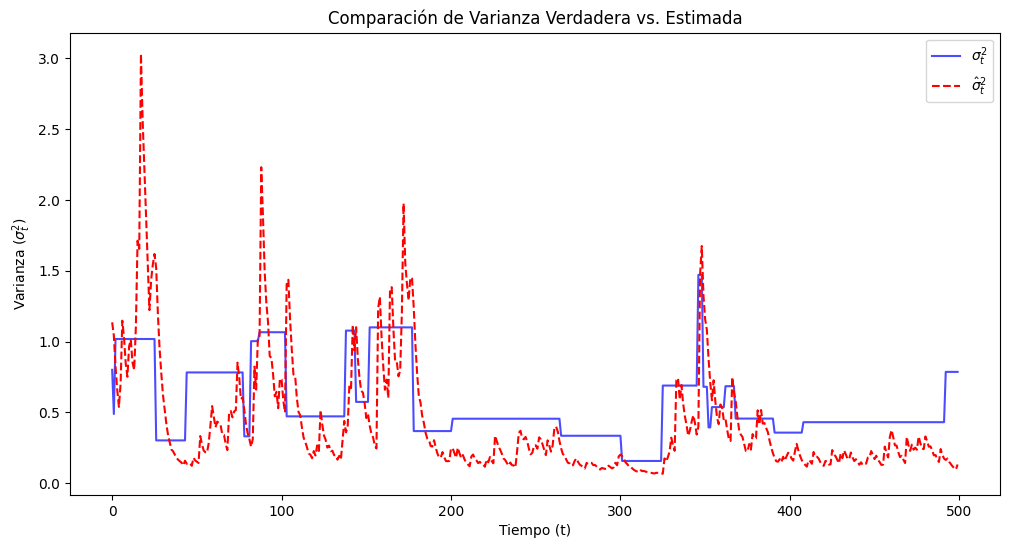

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(vsigma2t, label='$\sigma_t^2$', color='blue', alpha=0.7)
plt.plot(sigma2_tML, label='$\hat{\sigma}_t^2$', color='red', linestyle='--')
plt.title('Comparación de Varianza Verdadera vs. Estimada')
plt.xlabel('Tiempo (t)')
plt.ylabel('Varianza ($\sigma_t^2$)')
plt.legend()
plt.show()

Observamos una estimación muy similar a la efectuada con ruido normal, de hecho, es prácticamente idéntica en todos los parámetros, de modo que la interpretación es la misma que en el apartado anterior. De hecho, el gráfico es también prácticamente idéntico (lógicamente) y parece que este modelo ajusta, en efecto, bien también a los datos. Por tanto, no parece muy relevante la distinción entre ruido gaussiano o t-Student, a falta de pruebas estadísticas, para el GARCH($1,1$).

**Modelo para GARCH-M($1,1$) con innovaciones normales**

El GARCH-M(1,1) con innovaciones normales supone:

$$
y_t = \mu_t + a_t  \\
\mu_t = \mu + c\sigma^2_t \\
a_t = \sigma_t \epsilon_t \\
\epsilon_t \underset{iid}\sim N(0, 1) \\
\sigma^2_t = \alpha_0 + \alpha_1 a^2_{t-1} + \beta_1 \sigma^2_{t-1} \, , \\
\alpha_0 > 0 \, , 0 \leq \alpha_1, \beta_1 \leq 1 \, , \alpha_1+ \beta_1 \leq 1.
$$

Estas restricciones sobre los coeficientes son necesarias para que el proceso tenga varianza positiva y sea estacionario. No es necesario imponer ninguna restricción sobre $c$ para que el modelo sea estable, sin embargo, el GARCH-M supone que este parámetro es la prima de riesgo, i.e, un aumento de la volatilidad implica un aumento de la rentabilidad esperada. A mayor riesgo (varianza), los inversores solicitarán mayores rendimientos, por tanto, $c$ debería ser positivo. Si $c$ fuese $0$ o negativo, no debería de tener un sentido económico lógico esta especificación.

Para estimar el modelo, al cambiar la ecuación de media, tenemos que los residuos son los siguientes:

$$
a_t = y_t - \mu_t = y_t - \mu - c\sigma^2_t \,\, ,\\
$$

es decir, dependen de la estimación de la varianza de hoy, lo que queremos estimar. Por suerte, la varianza de hoy depende en exclusiva de los datos del día anterior, así que esto no debería suponer ningún problema a la hora de calcular la función de verosimilitud.

En concreto, la función de verosimilitud para el GARCH-M($1,1$), será igual que para el GARCH($1,1$), lógicamente, al tener innoviaciones gaussianas. Esto es:

$$
\mathcal{L}(a_1, \ldots, a_T | \alpha_0, \alpha_1, \beta_1) = \prod_{t=2}^T \frac{1}{\sqrt{2\pi\sigma^2_t}} \exp\left[-\frac{1}{2}\left(\frac{a_t}{\sigma_t}\right)^2\right]
$$

La diferencia radicará en el cálculo de las innovaciones $a_t$ con respecto del modelo anterior, donde asumimos como condición inicial $\sigma^2_1 = \frac{\alpha_0}{1-\alpha_1-\beta_1}$.

In [ ]:
mu_MML, phi_MML, alpha_0_MML, alpha_MML, beta_MML, c_ML, info_Moptimization = fit_AR_GARCH_M_ML_gaussian_noise_SLSQP(
    vyt,
    phi_0_seed=mu,
    phi_seed=[],
    kappa_seed=0.05,
    alpha_seed=[0.1],
    beta_seed=[0.7],
    c_seed=0.0
)

/content/HW02_Econometría_functions.py:496: OptimizeWarning: Unknown solver options: xatol
  info_optimization = minimize(
/content/HW02_Econometría_functions.py:419: RuntimeWarning: overflow encountered in square
  + u[:, t - np.arange(1, r + 1)]**2 @ alpha
/content/HW02_Econometría_functions.py:420: RuntimeWarning: invalid value encountered in matmul
  + h[:, t - np.arange(1, s + 1)] @ beta
/usr/local/lib/python3.12/dist-packages/scipy/stats/_distn_infrastructure.py:2106: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/content/HW02_Econometría_functions.py:460: RuntimeWarning: invalid value encountered in sqrt
  norm.logpdf(u, loc=0.0, scale=np.sqrt(h))
/content/HW02_Econometría_functions.py:414: RuntimeWarning: divide by zero encountered in scalar divide
  h[:, :delay] = kappa / (1.0 - np.sum(alpha) - np.sum(beta))


In [ ]:
results_data = {
    'Parámetro': ['mu', 'alpha_0', 'alpha_1', 'beta_1', 'c'],
    'Estimación': [
        mu_MML,
        alpha_0_MML,
        float(alpha_MML[0]) if np.ndim(alpha_MML) > 0 else alpha_MML,
        float(beta_MML[0]) if np.ndim(beta_MML) > 0 else beta_MML,
        c_ML
    ]
}
df_resultados = pd.DataFrame(results_data)
df_resultados.set_index('Parámetro', inplace=True)
print("Resultados de la Estimación (Maximum Likelihood):")
display(df_resultados.style.format("{:.6f}"))
print("\n--- Info Optimización ---")
print(f"Éxito: {info_Moptimization.success}")
print(f"Mensaje: {info_Moptimization.message}")
print(f"Iteraciones: {info_Moptimization.nit}")
print(f"Log-Verosimilitud Negativa Final: {info_Moptimization.fun:.4f}")

Resultados de la Estimación (Maximum Likelihood):


,Estimación
Parámetro,
mu,-0.009161
alpha_0,0.010053
alpha_1,0.176959
beta_1,0.809914
c,0.054538



--- Info Optimización ---
Éxito: True
Mensaje: Optimization terminated successfully
Iteraciones: 32
Log-Verosimilitud Negativa Final: 394.4579


In [ ]:
a_data = vyt - mu
a_MML, sigma2_MML = residuals_ARMA_GARCH_M(
    vyt,
    mu_MML,
    phi_MML,
    [],
    alpha_0_MML,
    alpha_MML,
    beta_MML,
    c_ML
)

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\h'
<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\h'
<>:6: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-2780125887.py:2: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(vsigma2t, label='$\sigma_t^2$', color='blue', alpha=0.7)
/tmp/ipython-input-2780125887.py:3: SyntaxWarning: invalid escape sequence '\h'
  plt.plot(sigma2_MML, label='$\hat{\sigma}_t^2$', color='red', linestyle='--')
/tmp/ipython-input-2780125887.py:6: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('Varianza ($\sigma_t^2$)')


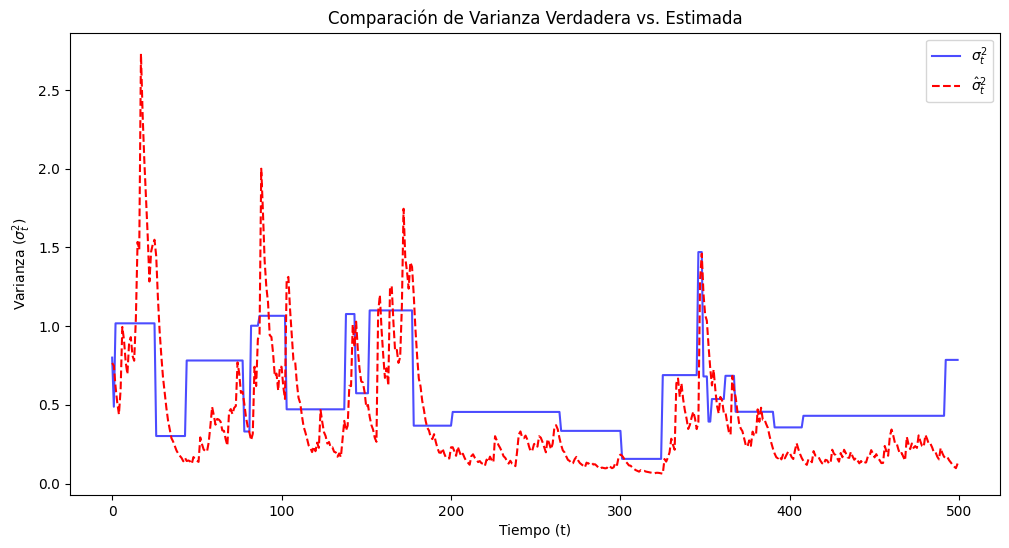

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(vsigma2t, label='$\sigma_t^2$', color='blue', alpha=0.7)
plt.plot(sigma2_MML, label='$\hat{\sigma}_t^2$', color='red', linestyle='--')
plt.title('Comparación de Varianza Verdadera vs. Estimada')
plt.xlabel('Tiempo (t)')
plt.ylabel('Varianza ($\sigma_t^2$)')
plt.legend()
plt.show()

De nuevo, obtenemos un gráfico y una estimación de los parámetros muy similar a las anteriores, donde parecemos tener un buen ajuste. Un matiz importante a comentar es que el signo de la estimación de $c$ en esta simulación es irrelevante ya que esto no son rendimientos de una serie temporal de un activo, por lo que la interpretación económica de este parámetro no tiene mucho sentido y podríamos encontrarnos con $c$ positivo o negativo sin que sea relevante. Lo relevante es si ajusta bien a los datos simulados o no.

**Modelo para EGARCH(1,1) con innovaciones normales:**

El EGARCH(1,1) con innovaciones normales supone:

$$
y_t = \mu_t + a_t  \\
\mu_t = \mu \\
a_t = \sigma_t \epsilon_t \\
\epsilon_t \underset{iid}\sim N(0, 1) \\
g(\epsilon_t) = \theta \epsilon_t + \gamma \left[ |\epsilon_t| - E(|\epsilon_t|) \right]  \Leftrightarrow \\
\Leftrightarrow g(\epsilon_t) = \begin{cases} \left(\theta + \gamma\right) \epsilon_t - \gamma E(|\epsilon_t|) \,\, \text{si} \, \epsilon_t \geq 0\\  \left(\theta - \gamma\right) \epsilon_t - \gamma E(|\epsilon_t|) \,\, \text{si} \, \epsilon_t < 0 \end{cases} \Leftrightarrow \\ \\
\Leftrightarrow g(\epsilon_t) \begin{cases} \left(\theta + \gamma\right) \epsilon_t - \gamma \sqrt{\frac{2}{\pi}} \,\, \text{si} \, \epsilon_t \geq 0\\  \left(\theta - \gamma\right) \epsilon_t - \gamma \sqrt{\frac{2}{\pi}} \,\, \text{si} \, \epsilon_t < 0 \end{cases}  \Leftrightarrow \\ \\
\Leftrightarrow g(a_t, \sigma_t) = \begin{cases} \left(\theta + \gamma\right) \frac{a_t}{\sigma_t} - \gamma \sqrt{\frac{2}{\pi}} \,\, \text{si} \, a_t \geq 0\\  \left(\theta - \gamma\right) \frac{a_t}{\sigma_t} - \gamma \sqrt{\frac{2}{\pi}} \,\, \text{si} \, a_t < 0 \end{cases} \Leftrightarrow \\ \\
\Leftrightarrow g(a_t, \sigma_t) = \begin{cases} \left(\alpha_1 \gamma_1 + \alpha_1\right) \frac{a_t}{\sigma_t} - \alpha_1 \sqrt{\frac{2}{\pi}} \,\, \text{si} \, a_t \geq 0\\  \left(\alpha_1 \gamma_1 - \alpha_1 \right) \frac{a_t}{\sigma_t} - \alpha_1 \sqrt{\frac{2}{\pi}} \,\, \text{si} \, a_t < 0 \end{cases}\Leftrightarrow \\ \\
\Leftrightarrow g(a_t, \sigma_t) = \frac{\alpha_1}{\sigma_t}\begin{cases} (\gamma_1 + 1) a_t - \alpha_1 \sqrt{\frac{2}{\pi}} \,\, \text{si} \, a_t \geq 0\\  (\gamma_1 - 1) a_t - \alpha_1 \sqrt{\frac{2}{\pi}} \,\, \text{si} \, a_t < 0 \end{cases}\Leftrightarrow \\ \\
\Leftrightarrow g(a_t, \sigma_t) = \alpha_1\frac{|a_t| + \gamma_1 a_t}{\sigma_t} - \alpha_1 \sqrt{\frac{2}{\pi}}\\ \\
\log\sigma^2_t = w + g(\epsilon_{t-1}) + \beta_1 \log\sigma^2_{t-1} \Leftrightarrow \\ \\
\Leftrightarrow \log\sigma^2_t = \alpha_0 + \alpha_1\frac{|a_{t-1}| + \gamma_1 a_{t-1}}{\sigma_{t-1}} + \beta_1 \log\sigma^2_{t-1} \, , \\
|\beta_1| < 1. \\
$$
Para que el proceso sea estacionario solo se requiere que $|\beta_1| < 1$, ya que es la condición de estacionariedad para un AR($1$). El resto de parámetros son libres, ya que al modelizar la varianza empleando el logaritmo esta siempre va a ser positiva.

En cuanto a la especificación del modelo, es diferente de los demás GARCH tratados ya que se incluye una función asimétrica de $\epsilon_t$ para diferenciar entre shocks positivos y negativos en la varianza, ya que empíricamente los shocks negativos afectan más a la volatilidad. En el último paso del desarrollo, como $\alpha_1 \sqrt{\frac{2}{\pi}}$ no influye en la estimación de los parámetros por ser una constante, esta es absorbida por $w$ convirtiéndose en $\alpha_0$, como hacemos notar.

Asimismo, también hacemos saber al lector que, dado que $\epsilon_t \underset{iid}\sim N(0, 1)$, se demuestra que (como se ve en el desarrollo anterior):

$$
E[|\epsilon_t|] = \int^{+\infty}_{-\infty} |\epsilon_t| \frac{1}{\sqrt{2\pi}}e^{\frac{-\epsilon^2_t}{2}} d\epsilon_t = \\
 = 2\int^{+\infty}_{0} \frac{1}{\sqrt{2\pi}}e^{-u_t} du_t = \\
 = 2 \frac{1}{\sqrt{2\pi}} \left(e^{-u_t} |^{+\infty}_0  \right) = \sqrt{\frac{2}{\pi}} \\
$$
empleando el cambio de variable $\frac{\epsilon^2_t}{2} = u_t$.

Escribimos la ecuación de la volatilidad en función de $a_t$ en vez de en función de $\epsilon_t$ como en otros casos ya que así es más sencilla su implementación para estimar el modelo. Además, el parámetro $\gamma_1$ lo podemos interpretar como el efecto apalancamiento. Este esperamos que sea negativo, de modo que si se dan shocks negativos influyan más en la volatilidad que un efecto del mismo nivel pero positivo.

Así, tendremos finalmente este modelo, obviando los pasos intermedios:

$$
y_t = \mu + a_t  \\
a_t = \sigma_t \epsilon_t \\
\epsilon_t \underset{iid}\sim N(0, 1) \\
\log\sigma^2_t = \alpha_0 + \alpha_1\frac{|a_{t-1}| + \gamma_1 a_{t-1}}{\sigma_{t-1}} + \beta_1 \log\sigma^2_{t-1} \, , \\
|\beta_1| < 1. \\
$$

Para su estimación, dado que no tenemos una solución cerrada de la varianza incondicional, simplemente asumiremos como condición inicial $\log\sigma^2_1 = \log \hat{\sigma}^2$, donde denotamos a $\hat{\sigma}^2$ como la varianza muestral. De nuevo, como las innovaciones son gaussianas, tenemos la misma función de verosimilitud que en los demás casos, la principal diferencia radica en el cálculo de la log-varianza:

$$
\mathcal{L}(a_1, \ldots, a_T | \alpha_0, \alpha_1, \beta_1) = \prod_{t=2}^T \frac{1}{\sqrt{2\pi\sigma^2_t}} \exp\left[-\frac{1}{2}\left(\frac{a_t}{\sigma_t}\right)^2\right]
$$

In [ ]:
mu_EML, phi_EML, alpha_0_EML, alpha_EML, beta_EML, gamma_ML, info_Eoptimization = fit_AR_EGARCH_ML_gaussian_noise_SLSQP(
    vyt,
    phi_0_seed=mu,
    phi_seed=[],
    kappa_seed=0.05,
    alpha_seed=[0.1],
    beta_seed=[0.7],
    gamma_seed=[0.0]
)

/content/HW02_Econometría_functions.py:629: OptimizeWarning: Unknown solver options: xatol
  info_optimization = minimize(
/content/HW02_Econometría_functions.py:559: RuntimeWarning: divide by zero encountered in divide
  + ( (np.abs(u[:, t - np.arange(1, r + 1)])
/content/HW02_Econometría_functions.py:558: RuntimeWarning: invalid value encountered in add
  kappa
/usr/local/lib/python3.12/dist-packages/scipy/stats/_distn_infrastructure.py:2106: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/content/HW02_Econometría_functions.py:561: RuntimeWarning: overflow encountered in exp
  ) / np.exp(0.5 * logh[:, t - np.arange(1, r + 1)])
/content/HW02_Econometría_functions.py:602: RuntimeWarning: overflow encountered in exp
  norm.logpdf(u, loc=0.0, scale=np.exp(0.5 *logh))


In [ ]:
results_data = {
    'Parámetro': ['mu', 'alpha_0', 'alpha_1', 'beta_1', 'gamma_1'],
    'Estimación': [
        mu_EML,
        alpha_0_EML,
        float(alpha_EML[0]) if np.ndim(alpha_EML) > 0 else alpha_EML,
        float(beta_EML[0]) if np.ndim(beta_EML) > 0 else beta_EML,
        float(gamma_ML[0]) if np.ndim(gamma_ML) > 0 else gamma_ML,
    ]
}
df_resultados = pd.DataFrame(results_data)
df_resultados.set_index('Parámetro', inplace=True)
print("Resultados de la Estimación (Maximum Likelihood):")
display(df_resultados.style.format("{:.6f}"))
print("\n--- Info Optimización ---")
print(f"Éxito: {info_Eoptimization.success}")
print(f"Mensaje: {info_Eoptimization.message}")
print(f"Iteraciones: {info_Eoptimization.nit}")
print(f"Log-Verosimilitud Negativa Final: {info_Eoptimization.fun:.4f}")

Resultados de la Estimación (Maximum Likelihood):


,Estimación
Parámetro,
mu,-0.000198
alpha_0,-0.347118
alpha_1,0.343579
beta_1,0.930124
gamma_1,-0.088070



--- Info Optimización ---
Éxito: True
Mensaje: Optimization terminated successfully
Iteraciones: 20
Log-Verosimilitud Negativa Final: 394.3279


In [ ]:
a_data = vyt - mu
a_EML, logsigma2_EML = residuals_ARMA_EGARCH(
    vyt,
    mu_EML,
    phi_EML,
    [],
    alpha_0_EML,
    alpha_EML,
    beta_EML,
    gamma_ML
)
sigma2_EML = np.exp(logsigma2_EML)

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\h'
<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\h'
<>:6: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-3807694052.py:2: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(vsigma2t, label='$\sigma_t^2$', color='blue', alpha=0.7)
/tmp/ipython-input-3807694052.py:3: SyntaxWarning: invalid escape sequence '\h'
  plt.plot(sigma2_EML, label='$\hat{\sigma}_t^2$', color='red', linestyle='--')
/tmp/ipython-input-3807694052.py:6: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('Varianza ($\sigma_t^2$)')


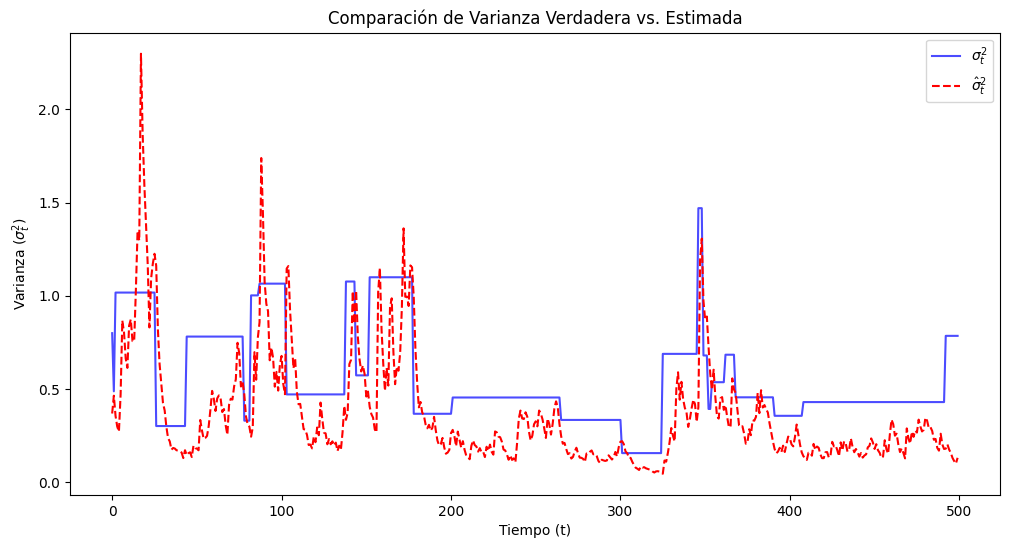

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(vsigma2t, label='$\sigma_t^2$', color='blue', alpha=0.7)
plt.plot(sigma2_EML, label='$\hat{\sigma}_t^2$', color='red', linestyle='--')
plt.title('Comparación de Varianza Verdadera vs. Estimada')
plt.xlabel('Tiempo (t)')
plt.ylabel('Varianza ($\sigma_t^2$)')
plt.legend()
plt.show()

Empleando este modelo, ahora sí que tenemos un gráfico ciertamente distinto de los demás GARCH. En primer lugar, tenemos estimaciones bastante diferentes de los parámetros del modelo, ya que como hemos indicado anteriormente, salvo $\beta_1$, los demás parámetros son libres y esto se nota claramente en el ajuste. Además, el parámetro $\gamma_1$, que indica el apalancamiento, parece que cumple su función y el gráfico de la volatilidad estimada parece que tiene más alteraciones que los demás con bajadas más bruscas. Este es negativo como debería, aunque de nuevo, al no ser una serie temporal de un activo, la interpretación económica no tiene mucho sentido incluirla en esta explicación.

**Modelo para TGARCH(1,1) con innovaciones normales**

El TGARCH($1,1$) con innovaciones normales supone:

$$
y_t = \mu_t + a_t  \\
\mu_t = \mu \\
a_t = \sigma_t \epsilon_t \\
\epsilon_t \underset{iid}\sim N(0, 1) \\
I(a_{t-1} < 0) = \begin{cases} 1 \,\, \text{si} \,\, a_{t-1} < 0 \\ 0 \,\, \text{si} \,\, a_{t-1} \geq 0 \end{cases}\\
\sigma^2_t = \alpha_0 + \left[ \alpha_1 + \gamma I(a_{t-1} < 0) \right]a^2_{t-1}+ \beta_1 \sigma^2_{t-1} \, , \\
E[\sigma^2_t] = \frac{\alpha_0}{1 - \alpha_1 - \beta_1 - \frac{\gamma}{2}} \Rightarrow \\
\Rightarrow \alpha_0 > 0 \, , 0 \leq \alpha_1, \beta_1 \, , \alpha_1+ \gamma \geq 0, \, \alpha_1 + \beta_1 + \frac{\gamma}{2} < 1.
$$

Estas son las restricciones sobre los coeficientes para que la varianza sea positiva ($\alpha_1+ \gamma \geq 0$) y para que el proceso sea estacionario ($\alpha_1 + \beta_1 + \frac{\gamma}{2} < 1$), las cuales derivamos del valor de la esperanza incondicional de la varianza.

En cuanto a la especificación del modelo, sucede lo mismo que con el EGARCH($1,1$), añadimos la función indicadora si el shock es negativo para permitir efectos asimétricos sobre la volatilidad si el shock es positivo o negativo, tal y como se corresponde con la evidencia empírica.

La estimación del modelo se hará como hasta ahora, minimizando la función de log-verosimilitud para innovaciones gaussianas, donde el cambio de modelo depende de la nueva estimación de los residuos:

$$
\mathcal{L}(a_1, \ldots, a_T | \alpha_0, \alpha_1, \beta_1) = \prod_{t=2}^T \frac{1}{\sqrt{2\pi\sigma^2_t}} \exp\left[-\frac{1}{2}\left(\frac{a_t}{\sigma_t}\right)^2\right]
$$

Empleando como condición inicial la varianza a largo plazo, $\sigma^2_1 = \frac{\alpha_0}{1 - \alpha_1 - \beta_1 - \frac{\gamma}{2}}$.

In [ ]:
mu_TML, phi_TML, alpha_0_TML, alpha_TML, beta_TML, gamma_TML, info_Toptimization = fit_AR_TGARCH_ML_gaussian_noise_SLSQP(
    vyt,
    phi_0_seed=mu,
    phi_seed=[],
    kappa_seed=0.05,
    alpha_seed=[0.1],
    beta_seed=[0.7],
    gamma_seed=0.0
)

/content/HW02_Econometría_functions.py:774: OptimizeWarning: Unknown solver options: xatol
  info_optimization = minimize(
/content/HW02_Econometría_functions.py:729: RuntimeWarning: invalid value encountered in sqrt
  norm.logpdf(u, loc=0.0, scale=np.sqrt(h))


In [ ]:
results_data = {
    'Parámetro': ['mu', 'alpha_0', 'alpha_1', 'beta_1', 'gamma'],
    'Estimación': [
        mu_TML,
        alpha_0_TML,
        float(alpha_TML[0]) if np.ndim(alpha_TML) > 0 else alpha_TML,
        float(beta_TML[0]) if np.ndim(beta_TML) > 0 else beta_TML,
        float(gamma_TML[0]) if np.ndim(gamma_TML) > 0 else gamma_TML,
    ]
}
df_resultados = pd.DataFrame(results_data)
df_resultados.set_index('Parámetro', inplace=True)
print("Resultados de la Estimación (Maximum Likelihood):")
display(df_resultados.style.format("{:.6f}"))
print("\n--- Info Optimización ---")
print(f"Éxito: {info_Toptimization.success}")
print(f"Mensaje: {info_Toptimization.message}")
print(f"Iteraciones: {info_Toptimization.nit}")
print(f"Log-Verosimilitud Negativa Final: {info_Toptimization.fun:.4f}")

Resultados de la Estimación (Maximum Likelihood):


,Estimación
Parámetro,
mu,0.001949
alpha_0,0.010173
alpha_1,0.161611
beta_1,0.811649
gamma,0.025424



--- Info Optimización ---
Éxito: True
Mensaje: Optimization terminated successfully
Iteraciones: 31
Log-Verosimilitud Negativa Final: 394.5550


In [ ]:
a_data = vyt - mu
a_TML, sigma2_TML = residuals_ARMA_TGARCH(
    vyt,
    mu_TML,
    phi_TML,
    [],
    alpha_0_TML,
    alpha_TML,
    beta_TML,
    gamma_TML
)

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\h'
<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\h'
<>:6: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-4051641769.py:2: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(vsigma2t, label='$\sigma_t^2$', color='blue', alpha=0.7)
/tmp/ipython-input-4051641769.py:3: SyntaxWarning: invalid escape sequence '\h'
  plt.plot(sigma2_TML, label='$\hat{\sigma}_t^2$', color='red', linestyle='--')
/tmp/ipython-input-4051641769.py:6: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('Varianza ($\sigma_t^2$)')


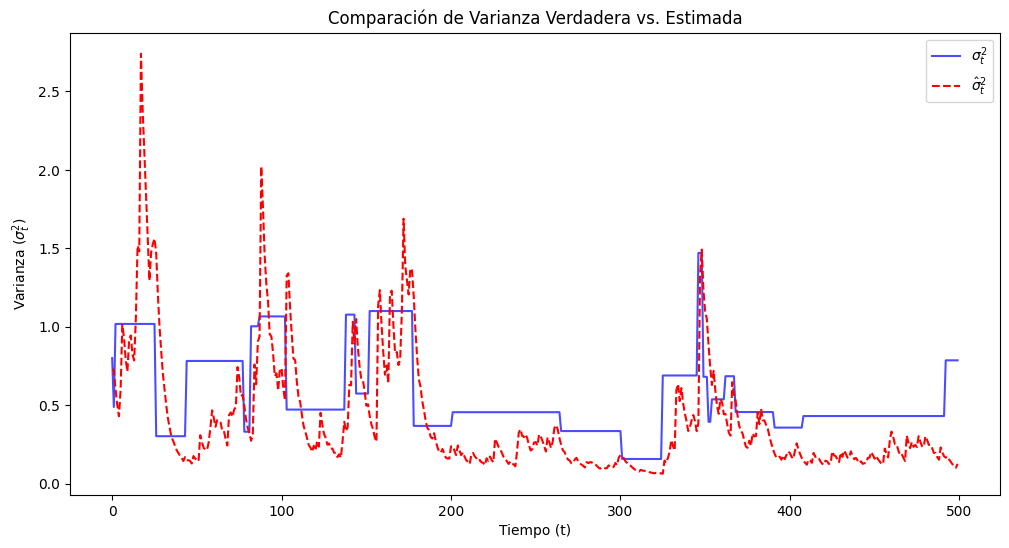

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(vsigma2t, label='$\sigma_t^2$', color='blue', alpha=0.7)
plt.plot(sigma2_TML, label='$\hat{\sigma}_t^2$', color='red', linestyle='--')
plt.title('Comparación de Varianza Verdadera vs. Estimada')
plt.xlabel('Tiempo (t)')
plt.ylabel('Varianza ($\sigma_t^2$)')
plt.legend()
plt.show()

De nuevo, obtenemos un gráfico muy similar al anterior GARCH asimétrico, con la diferencia de la estimación de los parámetros, ya que en este GARCH debemos incluir más restricciones.



Parece que todos los modelos propuestos generan una serie de gráficos y muy semejantes y todos tienen estimaciones parecidas de los datos, salvo los modelos asimétricos por la propia naturaleza de los modelos y sus distintos parámetros.

Vamos a incluir ahora una tabla comparando las estimaciones de todos los modelos y una ventana gráfica con todos las comparativas entre los modelos para que quede más claro esto:

In [ ]:
params_dict = {
    'Parameter': ['mu', 'alpha_0', 'alpha_1', 'beta_1', 'nu', 'c', 'gamma'],

    'GARCH(1,1)-Normal': [mu_ML, alpha_0_ML, float(alpha_ML[0]), float(beta_ML[0]), np.nan, np.nan, np.nan],

    'GARCH(1,1)-t_Student': [mu_tML, alpha_0_tML, float(alpha_tML[0]), float(beta_tML[0]), nu_ML, np.nan, np.nan],

    'GARCH(1,1)-M': [mu_MML, alpha_0_MML, float(alpha_MML[0]), float(beta_MML[0]), np.nan, c_ML, np.nan],

    'EGARCH(1,1)': [mu_EML, alpha_0_EML, float(alpha_EML[0]), float(beta_EML[0]), np.nan, np.nan, float(gamma_ML[0])],

    'TGARCH(1,1)': [mu_TML, alpha_0_TML, float(alpha_TML[0]), float(beta_TML[0]), np.nan, np.nan, gamma_TML]
}

df_params = pd.DataFrame(params_dict).set_index('Parameter')
df_params.index.name = None

print("Tabla de Estimaciones de Parámetros:")
display(df_params)

Tabla de Estimaciones de Parámetros:


,"GARCH(1,1)-Normal","GARCH(1,1)-t_Student","GARCH(1,1)-M","EGARCH(1,1)","TGARCH(1,1)"
mu,0.003970,0.006872,-0.009161,-0.000198,0.001949
alpha_0,0.009716,0.013152,0.010053,-0.347118,0.010173
alpha_1,0.174673,0.211372,0.176959,0.343579,0.161611
beta_1,0.813054,0.777046,0.809914,0.930124,0.811649
nu,NaN,5.705376,NaN,NaN,NaN
c,NaN,NaN,0.054538,NaN,NaN
gamma,NaN,NaN,NaN,-0.088070,0.025424


Como se puede ver, las estimaciones de los tres primeros modelos son prácticamente idénticas de los parámetros comunes. Incluso en el TGARCH($1,1$), a excepción de $\gamma$ evidentemente, las estimaciones son también semejantes a estos tres modelos, que parece que estiman de manera muy similar los parámetros GARCH comunes a todos los modelos. En principio, el modelo más diferente, lógicamente ya que sus parámetros son más libres, es el EGARCH($1,1$), donde obtenemos un modelo considerablemente diferente.

Veamos ahora los gráficos de las estimaciones de la volatilidad en comparación de la real:

<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\h'
<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\h'
<>:15: SyntaxWarning: invalid escape sequence '\s'
<>:18: SyntaxWarning: invalid escape sequence '\s'
<>:19: SyntaxWarning: invalid escape sequence '\h'
<>:22: SyntaxWarning: invalid escape sequence '\s'
<>:25: SyntaxWarning: invalid escape sequence '\s'
<>:26: SyntaxWarning: invalid escape sequence '\h'
<>:29: SyntaxWarning: invalid escape sequence '\s'
<>:32: SyntaxWarning: invalid escape sequence '\s'
<>:33: SyntaxWarning: invalid escape sequence '\h'
<>:36: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\h'
<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape 

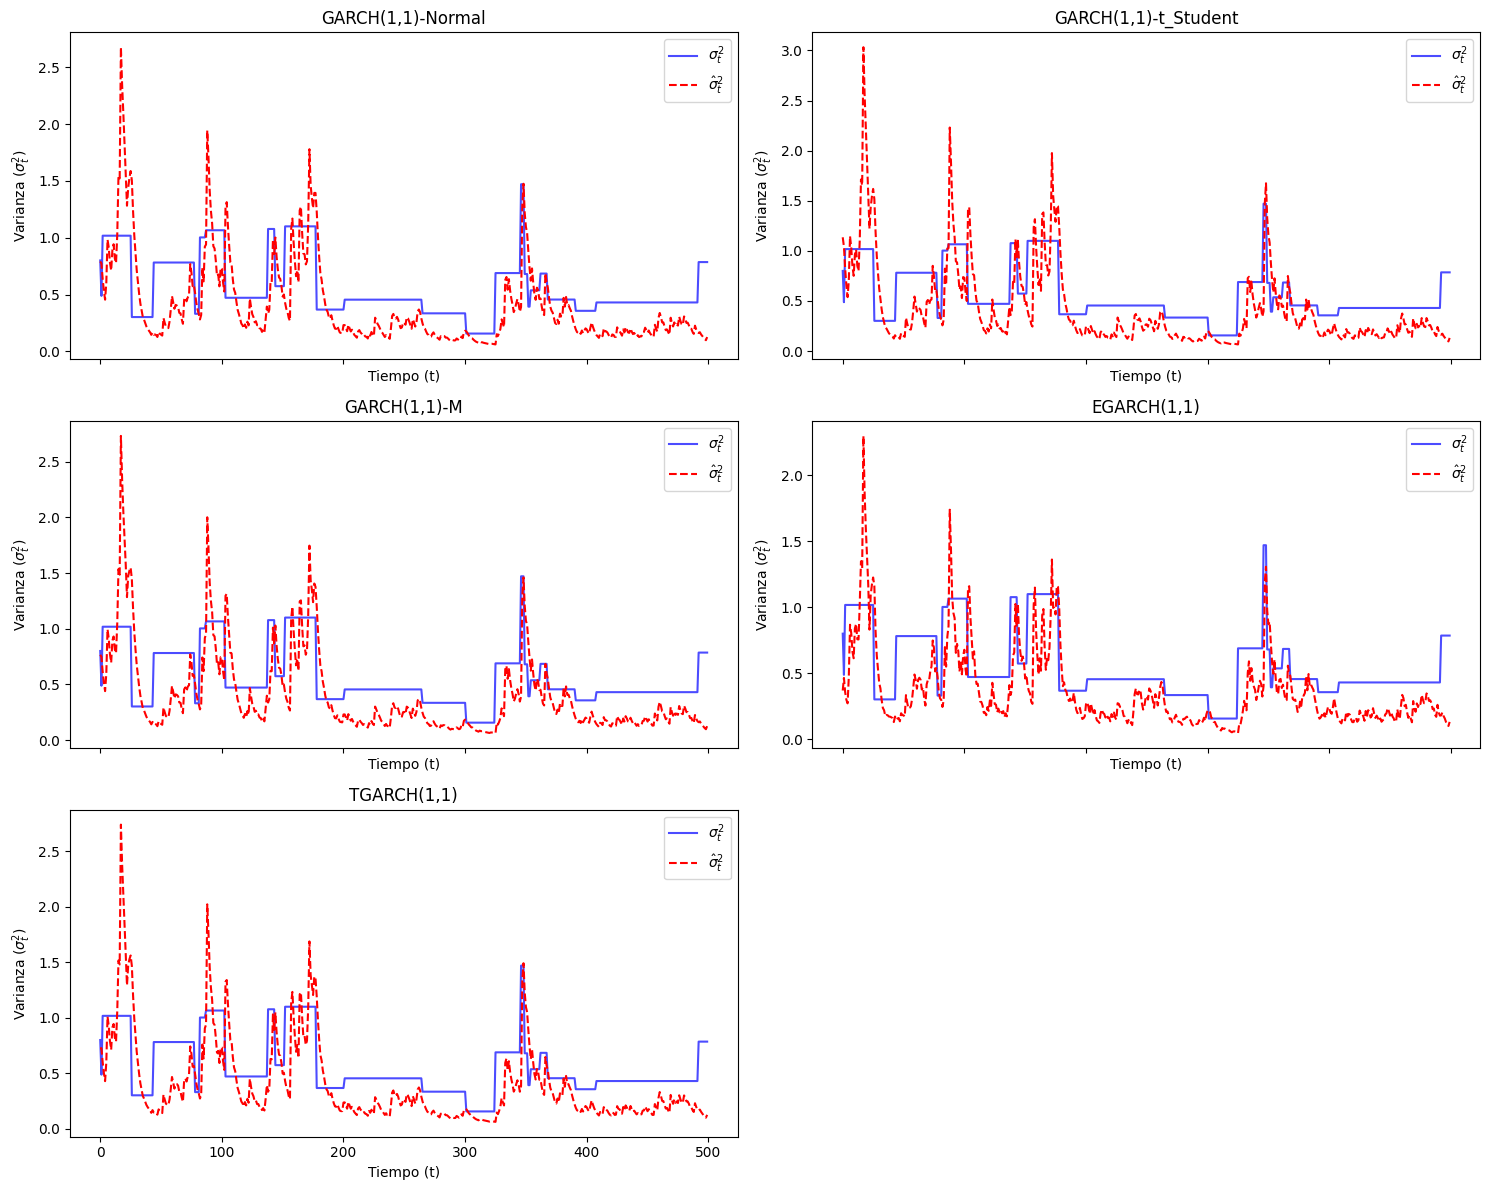

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(15, 12), sharex=True)
axes = axes.flatten()

axes[0].plot(vsigma2t, label='$\sigma_t^2$', color='blue', alpha=0.7)
axes[0].plot(sigma2_ML, label='$\hat{\sigma}_t^2$', color='red', linestyle='--')
axes[0].set_title('GARCH(1,1)-Normal')
axes[0].set_xlabel('Tiempo (t)')
axes[0].set_ylabel('Varianza ($\sigma_t^2$)')
axes[0].legend()

axes[1].plot(vsigma2t, label='$\sigma_t^2$', color='blue', alpha=0.7)
axes[1].plot(sigma2_tML, label='$\hat{\sigma}_t^2$', color='red', linestyle='--')
axes[1].set_title('GARCH(1,1)-t_Student')
axes[1].set_xlabel('Tiempo (t)')
axes[1].set_ylabel('Varianza ($\sigma_t^2$)')
axes[1].legend()

axes[2].plot(vsigma2t, label='$\sigma_t^2$', color='blue', alpha=0.7)
axes[2].plot(sigma2_MML, label='$\hat{\sigma}_t^2$', color='red', linestyle='--')
axes[2].set_title('GARCH(1,1)-M')
axes[2].set_xlabel('Tiempo (t)')
axes[2].set_ylabel('Varianza ($\sigma_t^2$)')
axes[2].legend()

axes[3].plot(vsigma2t, label='$\sigma_t^2$', color='blue', alpha=0.7)
axes[3].plot(sigma2_EML, label='$\hat{\sigma}_t^2$', color='red', linestyle='--')
axes[3].set_title('EGARCH(1,1)')
axes[3].set_xlabel('Tiempo (t)')
axes[3].set_ylabel('Varianza ($\sigma_t^2$)')
axes[3].legend()

axes[4].plot(vsigma2t, label='$\sigma_t^2$', color='blue', alpha=0.7)
axes[4].plot(sigma2_TML, label='$\hat{\sigma}_t^2$', color='red', linestyle='--')
axes[4].set_title('TGARCH(1,1)')
axes[4].set_xlabel('Tiempo (t)')
axes[4].set_ylabel('Varianza ($\sigma_t^2$)')
axes[4].legend()

axes[5].axis('off')

plt.tight_layout()
plt.show()

Prácticamente todos los gráficos son idénticos, como se suponía. Comparemos ahora criterios de información $AIC$ y $BIC$ para ver qué modelo es mejor, aunque tal y como se ve en la tabla y en los gráficos, prácticamente todos los modelos son idénticos. Esto probablemente se debe al proceso generador de datos, ya que es un ruido blanco con una deriva ínfima y una serie de la varianza constante con saltos, lo que hace que los ajustes de los GARCH sean muy parecidos y las irregularidades que están pensados para captar (colas más pesadas, prima por riesgo, respuestas asimétricas...) sean irrelevantes para este proceso generado, como hemos comentado previamente, ya que no se asemeja mucho a lo que podemos encontrar en una serie financiera.

Sin más dilación, comparemos los modelos. Estas son las fórmulas para el $AIC$ y el $BIC$:

$$
AIC = 2k - 2\ln(\hat{\mathcal{L}}) \\
BIC = k\ln(T) - 2\ln(\hat{\mathcal{L}}),
$$

donde $k$ es el número de parámetros del modelo ($4$ para el GARCH($1,1$) normal y $5$ para el resto de modelos).

In [ ]:
k_normal = 4
k = 5
modelos_info = [
    ("GARCH(1,1)-Normal", info_optimization, k_normal),
    ("GARCH(1,1)-t_Student", info_toptimization, k),
    ("GARCH(1,1)-M", info_Moptimization, k),
    ("EGARCH(1,1)", info_Eoptimization, k),
    ("TGARCH(1,1)", info_Toptimization, k)
]

resultados = []

for nombre, res, k in modelos_info:
    log_likelihood = -res.fun

    aic = 2*k - 2*log_likelihood
    bic = k*np.log(T) - 2*log_likelihood

    resultados.append({
        "Modelo": nombre,
        "Log-Likelihood": log_likelihood,
        "Num Params (k)": k,
        "AIC": aic,
        "BIC": bic
    })

df_criterios = pd.DataFrame(resultados)

df_criterios = df_criterios.sort_values(by="AIC")

print("Comparación de Modelos (Ordenados por mejor AIC):")
display(df_criterios)

mejor_aic = df_criterios.iloc[0]["Modelo"]
print(f"\nEl modelo preferido según AIC es: {mejor_aic}")

df_criterios = df_criterios.sort_values(by="BIC")

print("\n" * 2)

print("Comparación de Modelos (Ordenados por mejor BIC):")
display(df_criterios)

mejor_bic = df_criterios.iloc[0]["Modelo"]
print(f"\nEl modelo preferido según BIC es: {mejor_bic}")


Comparación de Modelos (Ordenados por mejor AIC):


,Modelo,Log-Likelihood,Num Params (k),AIC,BIC
1,"GARCH(1,1)-t_Student",-383.801473,5,777.602946,798.675987
0,"GARCH(1,1)-Normal",-394.623915,4,797.247830,814.106262
3,"EGARCH(1,1)",-394.327876,5,798.655752,819.728792
2,"GARCH(1,1)-M",-394.457906,5,798.915812,819.988852
4,"TGARCH(1,1)",-394.555007,5,799.110014,820.183055



El modelo preferido según AIC es: GARCH(1,1)-t_Student



Comparación de Modelos (Ordenados por mejor BIC):


,Modelo,Log-Likelihood,Num Params (k),AIC,BIC
1,"GARCH(1,1)-t_Student",-383.801473,5,777.602946,798.675987
0,"GARCH(1,1)-Normal",-394.623915,4,797.247830,814.106262
3,"EGARCH(1,1)",-394.327876,5,798.655752,819.728792
2,"GARCH(1,1)-M",-394.457906,5,798.915812,819.988852
4,"TGARCH(1,1)",-394.555007,5,799.110014,820.183055



El modelo preferido según BIC es: GARCH(1,1)-t_Student


Al comparar los modelos por $AIC$ y $BIC$ obtenemos la misma ordenación para ambos criterios y parece que el GARCH($1,1$) empleando innovaciones t-Student se lleva la palma en esta simulación, por lo que parece que esta distribución de los residuos es más adecuada que la normal.

El segundo modelo es el GARCH($1,1$) normal, ya que debemos estimar un parámetro menos que en los demás modelos, porque si nos fijamos en el valor de la función de verosimilitud, no es el segundo valor más bajo ni mucho menos. Igualmente, todos los criterios y funciones de verosimilitud tienen un valor muy similar, por lo que, como veníamos diciendo, no deberíamos tener especial preferencia por un modelo u otro ya que todos aportan resultados muy parecidos.


# Ejercicio 2

Elija un conjunto de precios de activos relacionados entre sí y:

*i)* Estime la volatilidad de los rendimientos de cada activo a
partir de algún modelo GARCH.

*ii)* Estime un VAR de los
logaritmos de las volatilidades estimadas.

*iii)* Realice un análisis de conectividad mediante una identificación generalizada, en la línea de Diebold y Yilmaz.




***i) Modelo GARCH para la volatilidad de cada activo***

Los activos escogidos para llevar a cabo el análisis son las acciones del Banco Santander, Iberdrola e Inditex, tres grandes compañias españolas incluidas en el IBEX35, cuyos rendimientos y actividades estan relacionadas por un componente geográfico.

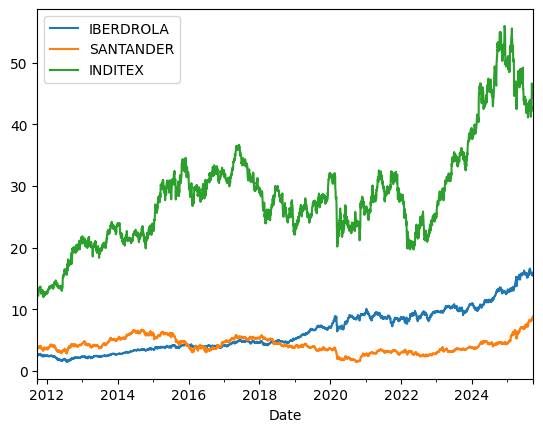

In [ ]:
precios = pd.read_csv(
    "datos_ej2p2.csv",
    sep=";",
    decimal=",",
    parse_dates=[0],
    dayfirst=True)

precios.rename(columns={"Unnamed: 0": "Date"}, inplace=True)
precios = precios.set_index(precios.columns[0])

precios.plot()
plt.legend()
plt.show()


La evolución de la cotización presenta similitudes, con un movimiento relativamente lateral entre 2012 y 2022 y un periodo alcista desde el 2022, con la diferencia del nivel en el precio de estas tres compañias.

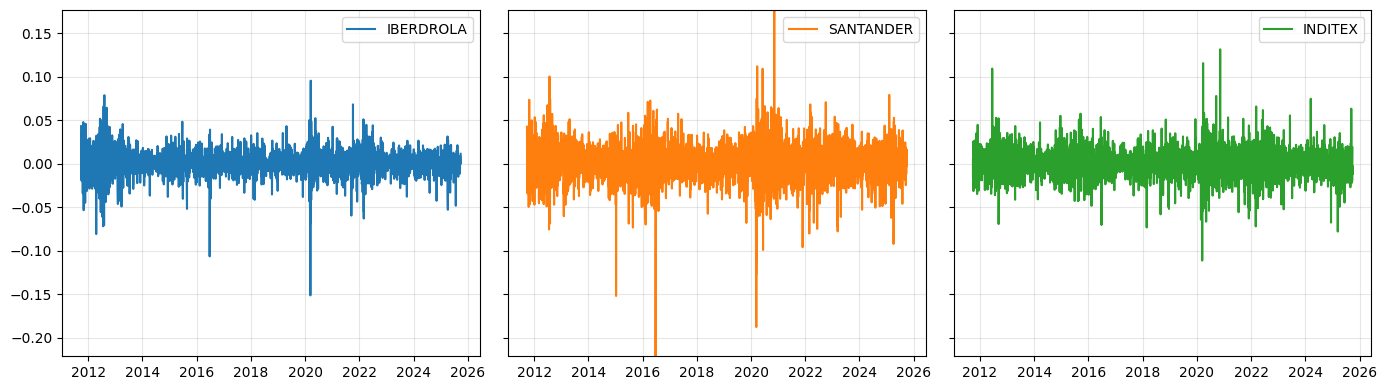

In [ ]:
rendimientos = np.log(precios / precios.shift(1)).dropna()

colors = ["tab:blue", "tab:orange", "tab:green"]
ymin, ymax = rendimientos.min().min(), rendimientos.max().max()

fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharey=True)

for ax, col, c in zip(axes, rendimientos.columns, colors):
    ax.plot(rendimientos[col], color=c, label=col)
    ax.set_ylim(ymin, ymax)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

La volatilidad de los rendimientos presenta una clara correlación: las tres empresas sufren momentos de alta volatilidad durante el mismo periodo de tiempo. Además, se observan agrupamientos de volatilidad en todas.
Los rendimientos del Santander parecen los mas volátiles, mientras que los de Iberdrola los mas estables.

La hipótesis de mercados eficientes establece que los rendimientos de las acciones son ruido blanco, es decir, procesos estocásticos con media cero y varianza constante. Sin embargo, este último supuesto parece no ajustarse a la evidencia empírica. Con el objetivo de determinar que distribución teórica se ajusta mejor a la distribución empírica de los rendimientos, ajustamos la distribución Normal y la t-Student a los datos.

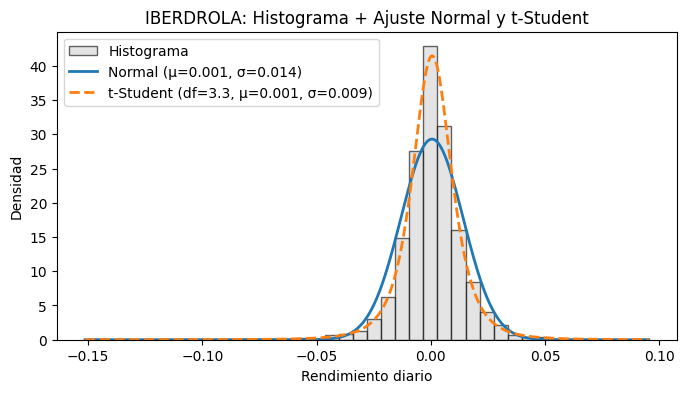

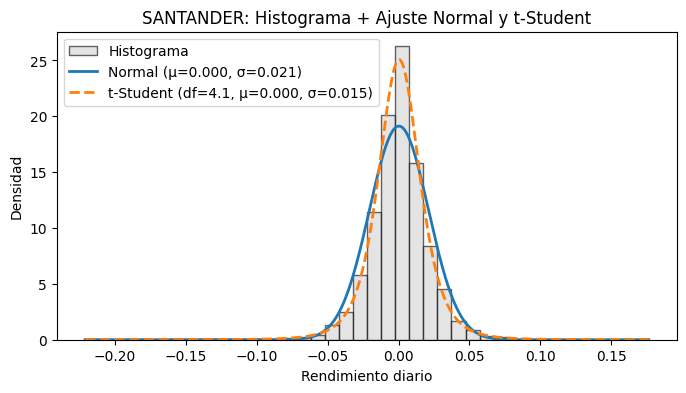

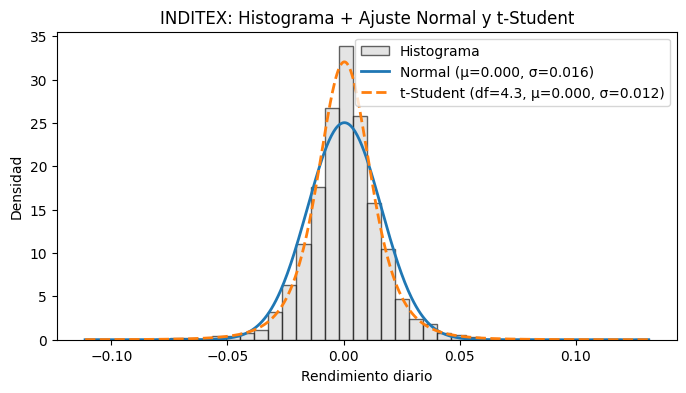

In [ ]:
series = {
    "IBERDROLA": rendimientos["IBERDROLA"].dropna(),
    "SANTANDER": rendimientos["SANTANDER"].dropna(),
    "INDITEX": rendimientos["INDITEX"].dropna()
}

for nombre, serie in series.items():

    # Ajuste a la Normal
    mu_norm, sigma_norm = norm.fit(serie)

    # Ajuste a la t-Student
    df_t, mu_t, sigma_t = stats.t.fit(serie)

    x = np.linspace(serie.min(), serie.max(), 500)

    pdf_norm = norm.pdf(x, mu_norm, sigma_norm)
    pdf_t = stats.t.pdf(x, df_t, loc=mu_t, scale=sigma_t)

    plt.figure(figsize=(8,4))

    # Histograma
    plt.hist(serie, bins=40, density=True, alpha=0.6,
             color='lightgray', edgecolor='black', label="Histograma")

    # Disttribución Normal ajustada
    plt.plot(x, pdf_norm, linewidth=2, label=f"Normal (μ={mu_norm:.3f}, σ={sigma_norm:.3f})")

    # Distribución t-Student ajustada
    plt.plot(
        x, pdf_t, linewidth=2, linestyle="--",
        label=f"t-Student (df={df_t:.1f}, μ={mu_t:.3f}, σ={sigma_t:.3f})"
    )

    plt.title(f"{nombre}: Histograma + Ajuste Normal y t-Student")
    plt.xlabel("Rendimiento diario")
    plt.ylabel("Densidad")
    plt.legend()
    plt.show()

Observamos que en los tres casos, el ajuste de la t-Student a la distribución de los rendimientos de los activos es mas precisa que el de la normal, dada la concentración de observaciones en torno a la media y la presencia de observaciones atípicas (distribución leptocúrtica). Por ello, estimamos el siguiente modelo para el rendimiento de cada activo i = IBERDROLA, SANTANDER, INDITEX:

$r_{i,t} = \mu + a_{i,t} \;$  donde $\; a_{i,t} = \sigma_{i,t} \epsilon_{i,t}, \; \epsilon_{i,t} \sim t_s(0, 1)$

$\sigma_{i,t}^2 = \gamma + \alpha a_{i, t-1}^2 + \beta \sigma_{i,t-1}^2   $

Dado que los datos son diarios, obervamos una media muestral de los rendimientos muy próxima a cero, por lo que asumimos $\mu = 0$. Además, escogemos un GARCH(1,1) por su eficacia (recoge los efectos de clustering y persistencia de los shocks) e interpretabilidad a la hora de estimar las volatilidades de los activos.

In [ ]:
modelo_iberdrola = arch_model(rendimientos["IBERDROLA"], vol='GARCH', p=1, q=1, mean="Zero", dist='t')
modelo_santander = arch_model(rendimientos["SANTANDER"], vol='GARCH', p=1, q=1, mean='Zero', dist='t')
modelo_inditex = arch_model(rendimientos["INDITEX"], vol='GARCH', p=1, q=1, mean='Zero', dist='t')

resultado_iberdrola = modelo_iberdrola.fit(disp='off')
resultado_santander = modelo_santander.fit(disp='off')
resultado_inditex = modelo_inditex.fit(disp='off')

/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001854. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004351. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base

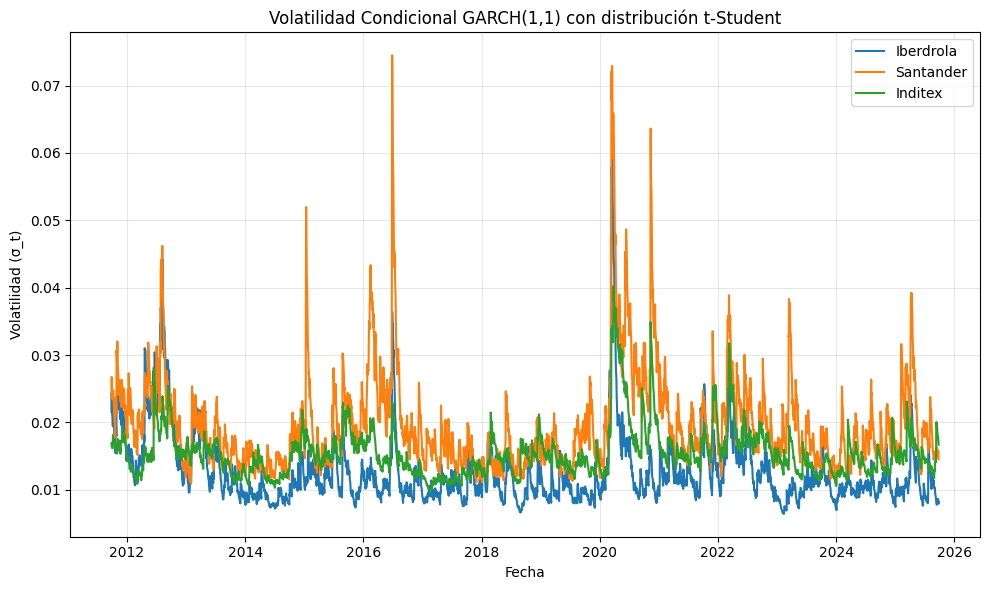

In [ ]:
# Volatilidades condicionales
vol_iberdrola  = resultado_iberdrola.conditional_volatility
vol_santander  = resultado_santander.conditional_volatility
vol_inditex    = resultado_inditex.conditional_volatility

plt.figure(figsize=(10,6))

plt.plot(vol_iberdrola, label="Iberdrola", linewidth=1.5)
plt.plot(vol_santander, label="Santander", linewidth=1.5)
plt.plot(vol_inditex, label="Inditex", linewidth=1.5)

plt.title("Volatilidad Condicional GARCH(1,1) con distribución t-Student")
plt.xlabel("Fecha")
plt.ylabel("Volatilidad (σ_t)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

Una vez estimados los modelos, estas son las series de volatilidad obtenidas. Se observa, por lo general, una mayor volatilidad del Banco Santander, seguido de Inditex y, por último, Iberdrola. Esta ordenación parece acorde a la actividad de cada una de estas empresas, pues los bancos estan relacionados con toda la actividad económica, al entablar relaciones con empresas de diversos sectores e Inditex presenta un modelo de negocio mas cíclico mientras que Iberdrola pertenece al sector de la energía, sector defensivo que se caracteriza por una demanda con menor relación con el ciclo económico. Por otro lado, observamos tanto una fuerte correlación entre la volatilidad de estas tres empresas como grandes agrupamientos de volatilidad. Cuando la volatilidad aumenta, lo hace en los tres activos y con cierta persistencia, mientras que cuando los rendimientos son estables, lo son, de la misma manera, en los tres activos y de forma continuada en el tiempo.

***ii) Modelo VAR para los logaritmos de las volatilidades estimadas***

<>:14: SyntaxWarning: invalid escape sequence '\D'
<>:14: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipython-input-3947186296.py:14: SyntaxWarning: invalid escape sequence '\D'
  plt.title("$\Delta \ln(\sigma_{i,t})$")


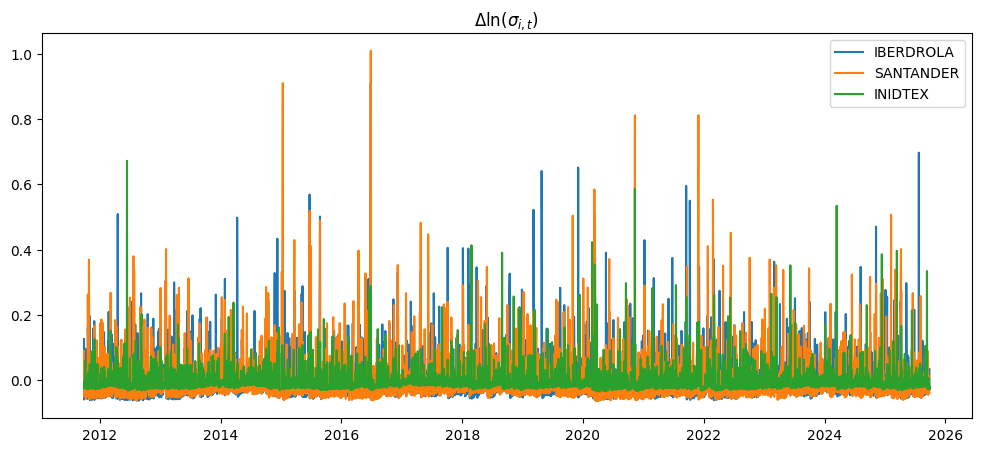

In [ ]:
ln_vol_iberdrola = np.log(resultado_iberdrola.conditional_volatility)
ln_vol_santander = np.log(resultado_santander.conditional_volatility)
ln_vol_inditex = np.log(resultado_inditex.conditional_volatility)

dln_vol = pd.DataFrame({
    "IBERDROLA": ln_vol_iberdrola.diff(),
    "SANTANDER": ln_vol_santander.diff(),
    "INDITEX":   ln_vol_inditex.diff()
}).dropna()

plt.figure(figsize=(12,5))
plt.plot(dln_vol, label=["IBERDROLA", "SANTANDER", "INIDTEX"])
plt.legend()
plt.title("$\Delta \ln(\sigma_{i,t})$")
plt.show()

El logaritmo de las volatilidades no es estacionario, por lo que tomamos la primera diferencia del logaritmo, de forma que, tal y como se observa, las series son estacionarias.

In [ ]:
# Estimar modelo VAR(p) con p=1,..., 10 y elegir modelo con menor AIC
modelo = VAR(dln_vol)
res = modelo.fit(maxlags=10, ic="aic")

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


El numero de retardos que minimiza el criterio  de información AIC es 4, por tanto, el modelo estimado es:

$y_t = \alpha + A_1 y_{t-1} + A_2 y_{t-2} + A_3 y_{t-3} + A_4 y_{t-4} + u_t$

donde
$y_t$ es un vector de tamaño 3 que incorpora las series $\Delta \ln \sigma_{i,t}$,\
$\alpha$ es un vector de constantes 3x1,\
$A_j$ es la matriz 3x3 que incorpora el efecto de $\Delta \ln \sigma_{i,t}$ sobre $\Delta \ln \sigma_{k,t}$ para todo $i,k =$ { Iberdrola, Santander, Inditex } en $j$ periodos,\
y $u_t$ es 3x3 i.i.d. como una N($0, \Sigma$), siendo $\Sigma$ la matriz de varianzas y covarianzas de los shocks.

Los coeficientes estimados de las matrices $\alpha$ y $A_j$ son los siguientes:

In [ ]:
vars = dln_vol.columns
p = res.k_ar
A = res.coefs
c = res.intercept

print("\alpha (vector de constantes):")
print(np.round(pd.DataFrame(c, index=vars, columns=["Constante"]),4))
print()

for i in range(p):
    print(f"A_{i+1}:")
    print(np.round(pd.DataFrame(A[i], index=vars, columns=vars), 4))
    print()

lpha (vector de constantes):
           Constante
IBERDROLA    -0.0003
SANTANDER    -0.0001
INDITEX       0.0000

A_1:
           IBERDROLA  SANTANDER  INDITEX
IBERDROLA    -0.0158     0.0350   0.0288
SANTANDER     0.0017    -0.0003   0.0037
INDITEX       0.0085     0.0096   0.0068

A_2:
           IBERDROLA  SANTANDER  INDITEX
IBERDROLA    -0.0165    -0.0002   0.0311
SANTANDER     0.0061    -0.0265   0.0419
INDITEX       0.0188     0.0111  -0.0142

A_3:
           IBERDROLA  SANTANDER  INDITEX
IBERDROLA    -0.0321     0.0348   0.0589
SANTANDER    -0.0252    -0.0103   0.0545
INDITEX       0.0125     0.0138   0.0034

A_4:
           IBERDROLA  SANTANDER  INDITEX
IBERDROLA    -0.0346     0.0164  -0.0190
SANTANDER     0.0207    -0.0298   0.0762
INDITEX       0.0197     0.0037  -0.0407



***iii) Análisis de conectividad***

Matriz de conectividad (Diebold-Yilmaz):

           IBERDROLA  SANTANDER   INDITEX  TOTAL
IBERDROLA   0.856958   0.107370  0.035672    1.0
SANTANDER   0.103400   0.835594  0.061006    1.0
INDITEX     0.038045   0.065433  0.896522    1.0


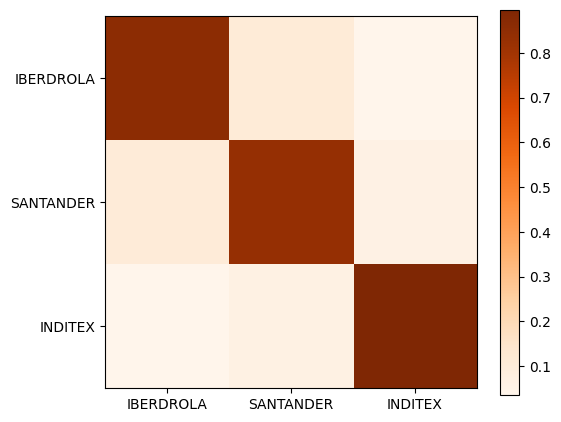

In [ ]:
theta = gfevd(res, H=10) #matriz de conectividad a horizonte 10 (2 semanas) de nuestro modelo VAR(4)

spill_to   = theta.sum(axis=1) - np.diag(theta) #cuanto envia cada empresa a otra
spill_from = theta.sum(axis=0) - np.diag(theta) #cuanto recibe cada empresa de otra
spill_net  = spill_to - spill_from #conectividad neta

dy_table = pd.DataFrame(theta, index=dln_vol.columns, columns=dln_vol.columns)
dy_table["TOTAL"] = dy_table.sum(axis=1) #suma por filas = 1
spillovers = pd.DataFrame({"TO": spill_to, "FROM": spill_from, "NET": spill_net}, index=dln_vol.columns)

print("Matriz de conectividad (Diebold-Yilmaz):")
print()
print(dy_table)

plt.figure(figsize=(6,5))
plt.imshow(theta, cmap="Oranges")
plt.xticks(range(3), dln_vol.columns)
plt.yticks(range(3), dln_vol.columns)
plt.colorbar()
plt.show()

La variabilidad en la volatilidad de cada una de las empresas esta principalmente causada por si misma. La varianza del error de previsión debida al propio shock de cada empresa explica en torno a un 85% de esta. En cuanto a la variabilidad no autoexplicada, Iberdrola y Santander parecen estar mas relacionadas, pues cada una de ellas explica el 10% de la variabilidad en la volatilidad de la otra, mientras que Inditex es mas independiente; Iberdrola y Santander tan solo explican el 3% y 6%, respectivamente, de la variablilidad de esta, asi como son afectadas por Inditex en una medida similar.

In [ ]:
print("\nTransmisión de volatilidad:")
print(spillovers)


Transmisión de volatilidad:
                 TO      FROM       NET
IBERDROLA  0.143042  0.141445  0.001597
SANTANDER  0.164406  0.172804 -0.008398
INDITEX    0.103478  0.096677  0.006801


La conectividad neta presenta un resultado claro; ninguna de las tres empresas podría considerarse el origen del riesgo sistémico, pues no son transmisores netos de volatilidad en gran medida. Santander es la empresa que mas recibe y transmite volatilidad, seguida de Iberdola y, por último, Inditex. Este ranking es el contrario al ranking de mayor variabilidad explicada por si mismo. Tanto Iberdrola como Inditex son transmisores netos, asi como Santander es receptor neto.

Estos resultados pueden ser explicados, tal y como comentamos anteriormente, el sector de actividad de cada una de las compañias. Por un lado, el Banco Santander establece relaciones (al financiar proyectos) con empresas de diversos sectores, por lo que su rendimiento esta sujeto al desempeño de ellas, asi como el desempeño de las compañias esta sujeto al desempeño del banco (cuanto mejor sea el desempeño del banco, mayor facilidad de acceso a la financiación), por lo que, tal y como vemos Santander es el mayor receptor y transmisor de volatilidad. Por otro lado, Iberdrola es el segundo transmisor y receptor de volatilidad, lo que puede ser causado por su actividad, pues la distribución de energía (debido al establecimiento de un precio) afecta al rendimiento del resto de empresas, asi como es dependiente de la demanda de energia de estas. Por último, Inditex parece ser la empresa menos conectada con el resto. En términos netos, el Santander es receptor neto de volatilidad dada su dependencia del resto de empresas, mientras que Iberdrola e Inditex son transmisores netos.

# Ejercicio 3

Elija series temporales con frecuencia diaria para el precio spot y el precio futuro de un activo. Sean $\nabla s_t$ y $\nabla f_t$ los rendimientos del spot y del futuro respectivamente. El ratio de cobertura de mínima varianza es el cociente de la covarianza incondicional del rendimiento spot y futuro ente la varianza del rendimiento futuro; esto equivale a computar la pendiente de una regresión como la siguiente:
$\nabla s_t = \gamma_0 + \gamma_1 \nabla f_t + u_t, \,\,\, u_t \underset{iid}\sim(0, \sigma^2) $. Calcule el ratio de cobertura condicional a la información en $t-1$ como sigue:
$$
\gamma_1 | \Omega_{t-1} = \frac{Cov(\nabla s_t, \nabla f_t | \Omega_{t-1})}{Var(\nabla f_t | \Omega_{t-1})} \\
$$
utilizando un modelo BEKK-GARCH o DCC-GARCH para estimar tanto la covarianza condicional como la varianza condicional. Evalúe la efectividad de la cobertura usando el modelo de regresión para estimar el ratio de cobertura frente a la efectividad obtenida cuando se evalúa el ratio de cobertura a partir de las estimaciones del modelo GARCH multivariante. Compare los resultados de efectividad cuando utiliza una estimación Markov-Switching con dos estados del modelo de regresión: $\nabla s_t = \gamma_{0,S_t} + \gamma_{1, S_t} \nabla f_t + u_t, \,\,\, u_t \underset{iid}\sim(0, \sigma^2)$, donde $S_t$ es una variable aleatoria que toma los valores $\{1, 2\}$ y sigue un proceso de Markov de primer orden. En este caso, el parámetro del ratio de cobertura sería:
$$
\hat{\gamma}_{1,t|t-1} = \hat{\xi}_{1,t|t-1}\hat{\gamma}_{1,S_t=1} + (1-\hat{\xi}_{1,t|t-1})\hat{\gamma}_{1,S_t=2} \\
$$
donde $\hat{\xi}_{1,t|t-1}$ es la probabilidad estimada de estar en el régimen
$1$ condicional al conjunto de información $\Omega_{t-1}$.

In [ ]:
datos = pd.read_excel("Datos_historicos.xlsx", index_col="Fecha")

**Ratio de cobertura de minima varianza MCO (constante)**

El ratio de cobertura $ \gamma_{MCO} = \frac{\sigma_{S,F}}{\sigma^2_{F}}$ se obtiene de la regresión $r_S = \alpha + \gamma_{MCO}r_F + u_t$

In [ ]:
returns = np.log(datos).diff()[1:]
returns.columns = ["futuro", "spot"]

Y = returns["spot"]
X = returns["futuro"]
X = sm.add_constant(X)

modelo1 = sm.OLS(Y, X).fit()

HR_OLS = modelo1.params[1]

hedge_strategy_ols = returns["spot"] - HR_OLS * returns["futuro"]

efectividad_ols = np.var(hedge_strategy_ols)

print(f'El ratio de cobertura es {np.round(HR_OLS,4)}')
print(f'El rendimiento promedio de la estrategia de cobertura es {np.round(np.mean(hedge_strategy_ols)*100, 4)}%')
print(f'La varianza de la cobertura, su efectividad, es del {np.round(efectividad_ols*100,4)}%')

El ratio de cobertura es 0.064
El rendimiento promedio de la estrategia de cobertura es 0.0284%
La varianza de la cobertura, su efectividad, es del 0.0075%


/tmp/ipython-input-2778241798.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  HR_OLS = modelo1.params[1]


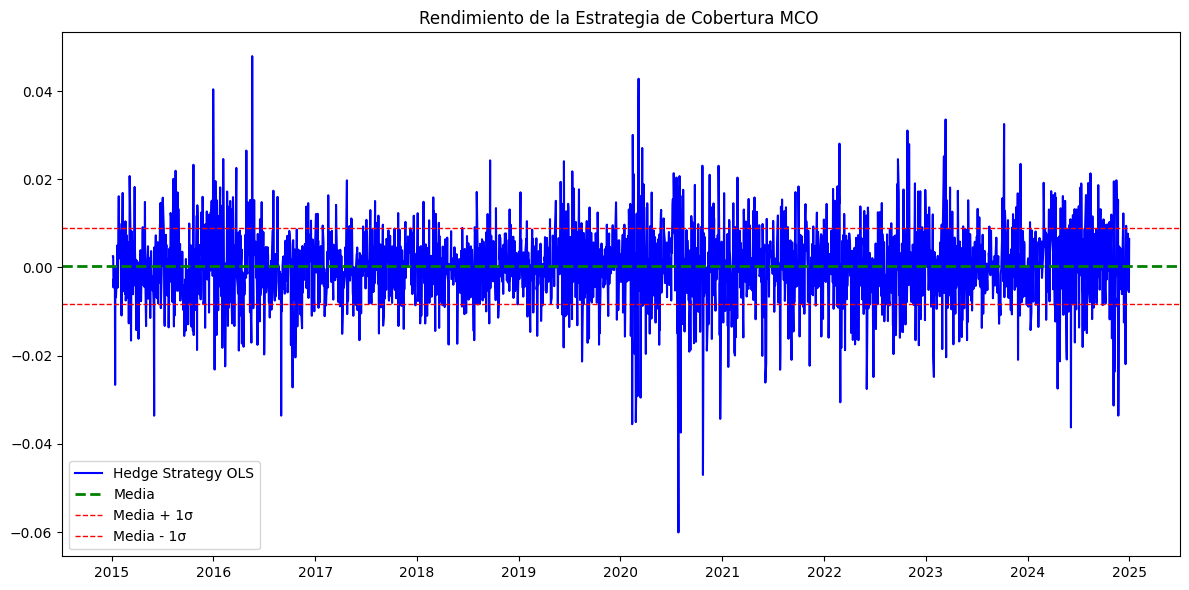

In [ ]:
media_ols = hedge_strategy_ols.mean()
sigma_ols = hedge_strategy_ols.std()

plt.figure(figsize=(12, 6))

plt.plot(hedge_strategy_ols, label="Hedge Strategy OLS", color="blue")
plt.axhline(media_ols, color="green", linestyle="--", linewidth=2, label="Media")
plt.axhline(media_ols + sigma_ols, color="red", linestyle="--", linewidth=1, label="Media + 1σ")
plt.axhline(media_ols - sigma_ols, color="red", linestyle="--", linewidth=1, label="Media - 1σ")

plt.title("Rendimiento de la Estrategia de Cobertura MCO ")
plt.legend()
plt.tight_layout()
plt.show()


**Ratio de cobertura con DCC-GARCH**

El modelo DCC-GARCH establece que la matriz de correlaciones, $R_t$, es $R_t = [diag(Q_t)]^{-\frac{1}{2}} Q_t  [diag(Q_t)]^{-\frac{1}{2}}$ donde $Q_t = (1 - \alpha - \beta)Q + \alpha \hat \epsilon_{t-1} \hat \epsilon_{t-1}' + \beta Q_{t-1}$

El ratio de cobertura dinámico, $\gamma_{DCC} = \rho_{(S,F),t} \frac{\sigma_{S,t}}{\sigma_{F,t}}$, se obtiene estimando $\sigma_i$ para $i =$ {Spot, Futuro} con un modelo GARCH y obteniendo $\rho_{S,F}$ de $R_t$.

1) Estimación GARCH(1,1) para el rendimiento spot y futuro

$r_{i,t} = \mu_i + a_{i,t}$

$\sigma^2_{i,t} = \alpha_{0,i} + \alpha_{1,i} a^2_{i, t-1} + \beta_i \sigma^2_{i, t-1}$

donde, dada la muestra, asumimos $\mu_i = 0 $ $     \forall i$

In [ ]:
garch_spot = arch_model(returns["spot"], vol='GARCH', p=1, q=1, mean="Zero", dist='t')
garch_futuro = arch_model(returns["futuro"], vol='GARCH', p=1, q=1, mean="Zero", dist='t')

resultado_spot = garch_spot.fit(disp='off')
resultado_futuro = garch_futuro.fit(disp='off')

/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 7.503e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 8.439e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)


2) Obtener residuos estandarizados $\epsilon_{i,t} = \frac{r_{i,t}}{\sigma_{i,t}}$

In [ ]:
vol_spot = resultado_spot.conditional_volatility
vol_futuro = resultado_futuro.conditional_volatility

eps_spot = returns["spot"] / vol_spot
eps_futuro = returns["futuro"] / vol_futuro

3) Estimar $\alpha$ y $\beta$ y obtener la correlación dinámica $R_t$

In [ ]:
eps_est = np.column_stack([eps_spot, eps_futuro])   # matriz T x 2

def objective(thtr):
  lfv, _ = lfv_DCC(thtr, eps_est)
  return lfv   # ya es positiva

# valores iniciales
x0 = np.array([0.1, 0.1])

# optimización
res = minimize(objective, x0, method='BFGS')

thtr_hat = res.x

# Convertimos a alpha y beta reales
alpha_hat = np.exp(thtr_hat[0]) / (1 + np.exp(thtr_hat[0]) + np.exp(thtr_hat[1]))
beta_hat  = np.exp(thtr_hat[1]) / (1 + np.exp(thtr_hat[0]) + np.exp(thtr_hat[1]))

print("alpha =", alpha_hat)
print("beta  =", beta_hat)

_, rho_series = lfv_DCC(thtr_hat, eps_est)

alpha = 0.43880203593900463
beta  = 3.3504718046147087e-07


4) Calcular ratio de cobertura y efectividad de la estrategia

El rendimiento promedio de la estrategia de cobertura es 0.0167%
La varianza de la cobertura, su efectividad, es del 0.0051%


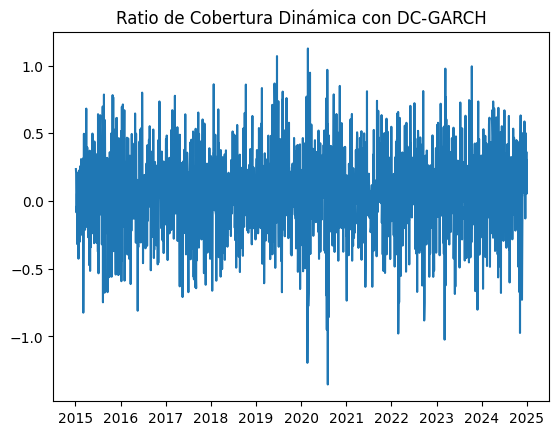

In [ ]:
HR_DCC = rho_series * (vol_spot / vol_futuro)

plt.plot(HR_DCC)
plt.title("Ratio de Cobertura Dinámica con DC-GARCH")

hedge_strategy_dcc = returns["spot"] - HR_DCC * returns["futuro"]

efectividad_dcc = np.var(hedge_strategy_dcc)

print(f'El rendimiento promedio de la estrategia de cobertura es {np.round(np.mean(hedge_strategy_dcc)*100, 4)}%')
print(f'La varianza de la cobertura, su efectividad, es del {np.round(efectividad_dcc*100,4)}%')

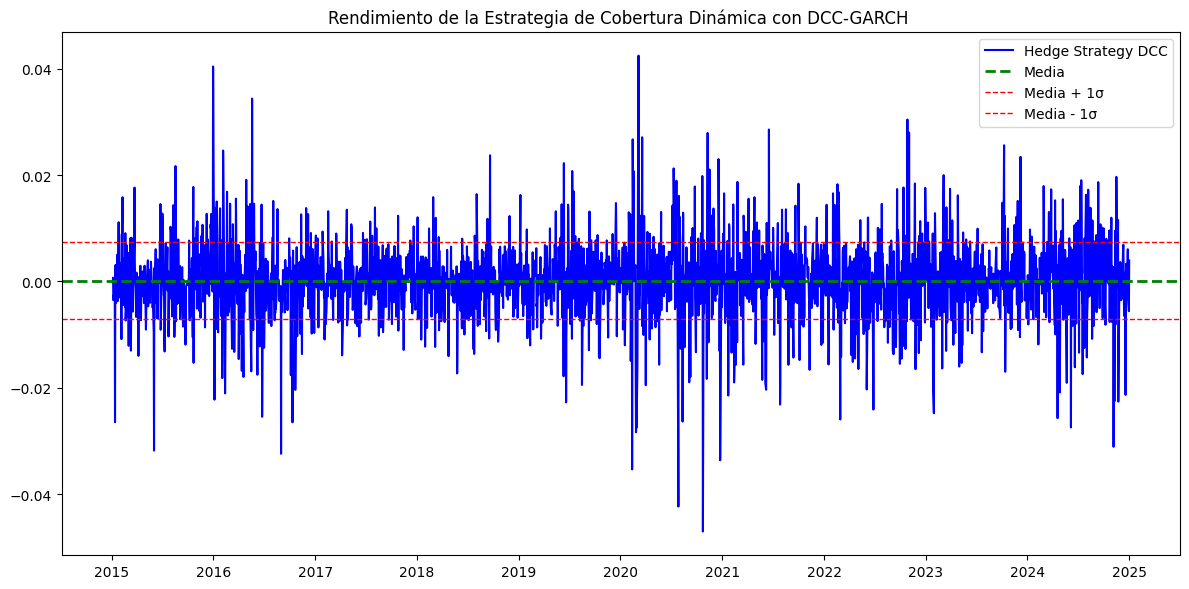

In [ ]:
media_dcc = hedge_strategy_dcc.mean()
sigma_dcc = hedge_strategy_dcc.std()

plt.figure(figsize=(12, 6))

plt.plot(hedge_strategy_dcc, label="Hedge Strategy DCC", color="blue")
plt.axhline(media_dcc, color="green", linestyle="--", linewidth=2, label="Media")
plt.axhline(media_dcc + sigma_dcc, color="red", linestyle="--", linewidth=1, label="Media + 1σ")
plt.axhline(media_dcc - sigma_dcc, color="red", linestyle="--", linewidth=1, label="Media - 1σ")

plt.title("Rendimiento de la Estrategia de Cobertura Dinámica con DCC-GARCH ")
plt.legend()
plt.tight_layout()
plt.show()

**Ratio de cobertura con modelo Markov-Switching**

El ratio de cobertura se obtiene a partir de la regresión:

$$
\Delta s_t = \gamma_{0,s_t} + \gamma_{1,s_t} \Delta f_t + u_t, \quad \text{donde } u_t \sim \mathcal{N}(0, \sigma^2_{s_t})
$$

donde $s_t \in \{1, 2\}$ representa el régimen o estado.

La estimación del ratio de cobertura en el tiempo $t$, condicional a la información disponible hasta $t-1$, denotada como $\Omega_{t-1}$, es:

$$
\hat{\gamma}{1,t \mid t-1} = \hat{\xi}{s=1,t \mid t-1} \hat{\gamma}{1,s=1} + \left(1 - \hat{\xi}{s=1,t \mid t-1}\right) \hat{\gamma}_{1,s=2}
$$

donde $\hat{\xi}{s=1,t \mid t-1}$ es la probabilidad estimada de estar en el régimen 1, condicional a $\Omega{t-1}$.



/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/content/HW02_Econometría_functions.py:154: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gamma1_regime1 = params[gamma1_idx[0]]
/content/HW02_Econometría_functions.py:155: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gamma1_regime2 = params[gamma1_idx[1]]


Text(0.5, 1.0, 'Ratio de Cobertura Dinámica con Markov-Switching')

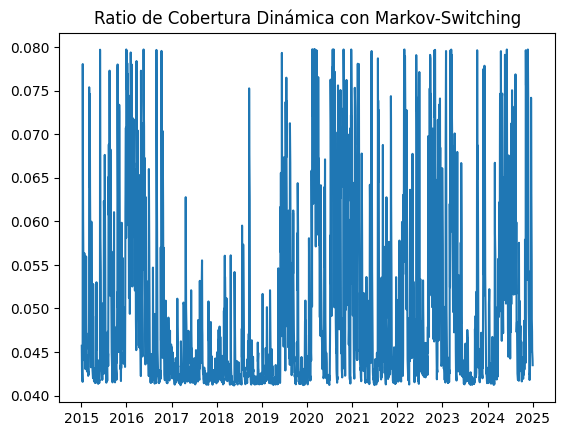

In [ ]:
out = dynamic_hedge_ratio_MS(returns)

HR_MS = out["hedge_ratio"]

plt.plot(HR_MS)
plt.title("Ratio de Cobertura Dinámica con Markov-Switching")

In [ ]:
hedge_strategy_ms = returns["spot"] - HR_MS * returns["futuro"]

efectividad_ms = np.var(hedge_strategy_ms)

print(f'El rendimiento promedio de la estrategia de cobertura es {np.round(np.mean(hedge_strategy_ms)*100, 4)}%')
print(f'La varianza de la cobertura, su efectividad, es del {np.round(efectividad_ms*100,4)}%')

El rendimiento promedio de la estrategia de cobertura es 0.0286%
La varianza de la cobertura, su efectividad, es del 0.0075%


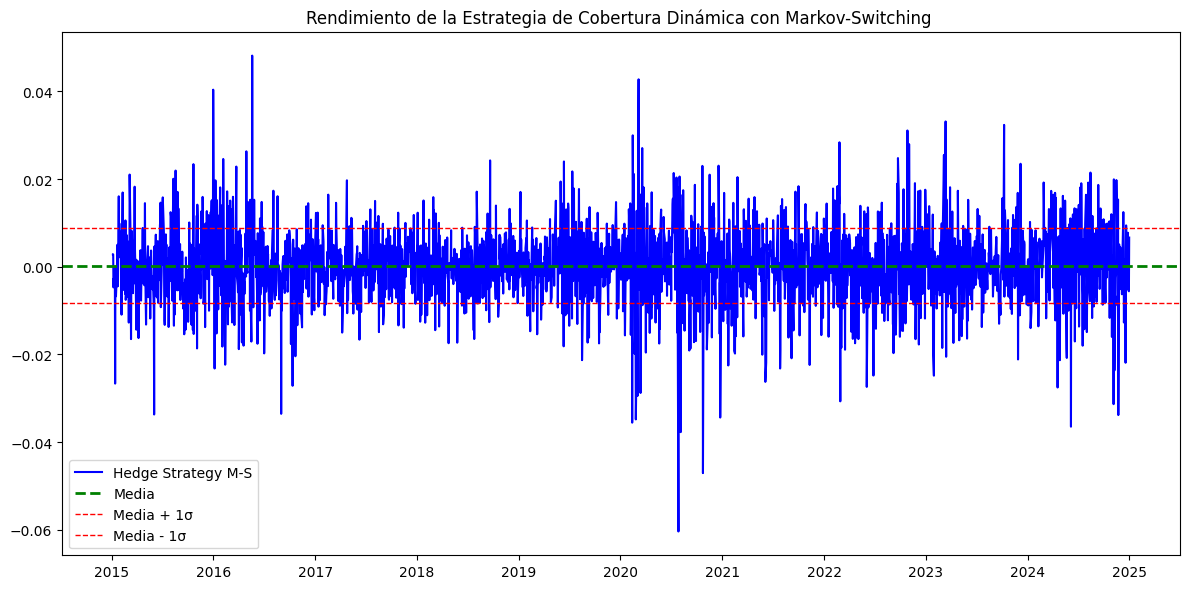

In [ ]:
media_ms = hedge_strategy_ms.mean()
sigma_ms = hedge_strategy_ms.std()

plt.figure(figsize=(12, 6))

plt.plot(hedge_strategy_ms, label="Hedge Strategy M-S", color="blue")
plt.axhline(media_ms, color="green", linestyle="--", linewidth=2, label="Media")
plt.axhline(media_ms + sigma_ms, color="red", linestyle="--", linewidth=1, label="Media + 1σ")
plt.axhline(media_ms - sigma_ms, color="red", linestyle="--", linewidth=1, label="Media - 1σ")

plt.title("Rendimiento de la Estrategia de Cobertura Dinámica con Markov-Switching ")
plt.legend()
plt.tight_layout()
plt.show()

**Resumen de las tres estrategias**

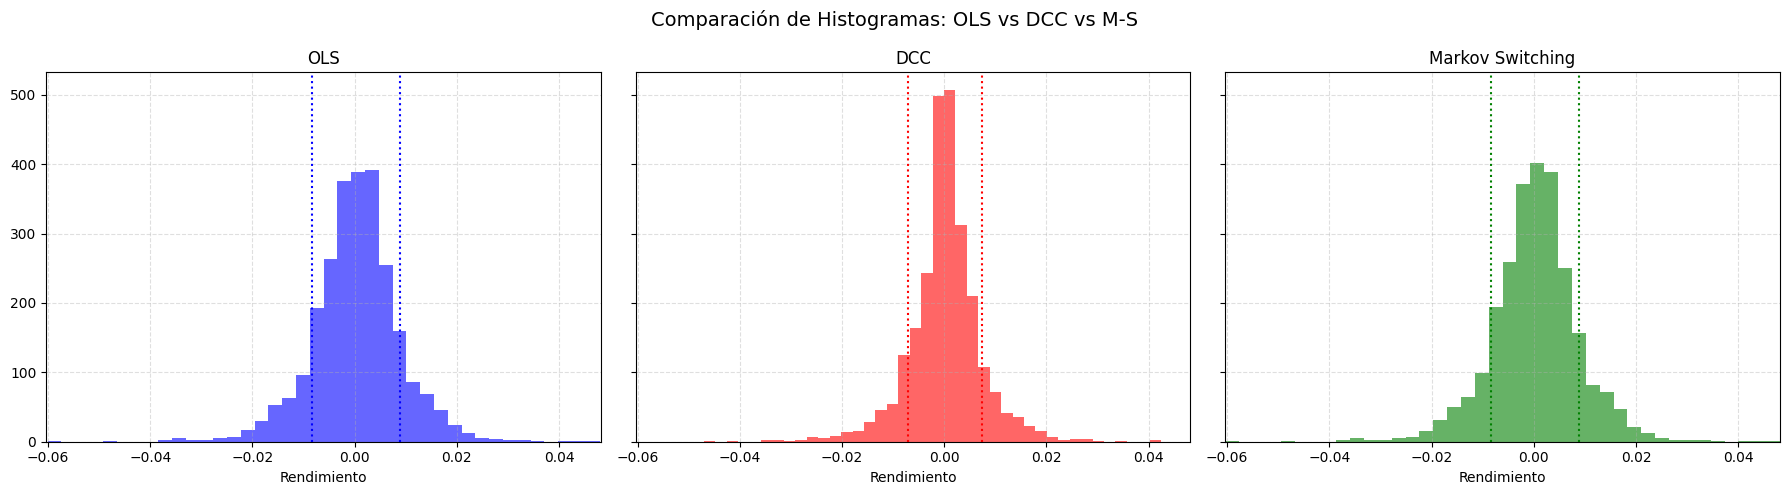

In [ ]:
xmin = min(
    hedge_strategy_ols.min(),
    hedge_strategy_dcc.min(),
    hedge_strategy_ms.min()
)

xmax = max(
    hedge_strategy_ols.max(),
    hedge_strategy_dcc.max(),
    hedge_strategy_ms.max()
)

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

#MCO
axes[0].hist(hedge_strategy_ols, bins=40, alpha=0.6, color='blue')
axes[0].axvline(media_ols + sigma_ols, color='blue', linestyle=':', linewidth=1.5)
axes[0].axvline(media_ols - sigma_ols, color='blue', linestyle=':', linewidth=1.5)
axes[0].set_title("OLS")
axes[0].set_xlabel("Rendimiento")
axes[0].set_xlim(xmin, xmax)
axes[0].grid(True, linestyle='--', alpha=0.4)

#DCC
axes[1].hist(hedge_strategy_dcc, bins=40, alpha=0.6, color='red')
axes[1].axvline(media_dcc + sigma_dcc, color='red', linestyle=':', linewidth=1.5)
axes[1].axvline(media_dcc - sigma_dcc, color='red', linestyle=':', linewidth=1.5)
axes[1].set_title("DCC")
axes[1].set_xlabel("Rendimiento")
axes[1].set_xlim(xmin, xmax)
axes[1].grid(True, linestyle='--', alpha=0.4)

#M-S
axes[2].hist(hedge_strategy_ms, bins=40, alpha=0.6, color='green')
axes[2].axvline(media_ms + sigma_ms, color='green', linestyle=':', linewidth=1.5)
axes[2].axvline(media_ms - sigma_ms, color='green', linestyle=':', linewidth=1.5)
axes[2].set_title("Markov Switching")
axes[2].set_xlabel("Rendimiento")
axes[2].set_xlim(xmin, xmax)
axes[2].grid(True, linestyle='--', alpha=0.4)

plt.suptitle("Comparación de Histogramas: OLS vs DCC vs M-S", fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
print(f'Efectividad cobertura MCO: {np.round(efectividad_ols*100,4)}%')
print(f'Efectividad cobertura DCC: {np.round(efectividad_dcc*100,4)}%')
print(f'Efectividad cobertura M-S: {np.round(efectividad_ms*100,4)}%')

Efectividad cobertura MCO: 0.0075%
Efectividad cobertura DCC: 0.0051%
Efectividad cobertura M-S: 0.0075%


Una estrategia de cobertura óptima debe producir una distribución de rendimientos centrada en 0 (idealmente solo tendría obervaciones en dicho valor). Las distribuciones de las tres estrategias de cobertura, presentados arriba, muestran un gran apuntamiento en torno al 0, claramente mayor en el caso de la estrategia con cobertura con el modelo DCC-GARCH. Por lo que, a priori, parece ser la cobertura mas efectiva. Midiendo la efectividad de la cobertura como la varianza de su rendimiento, vemos que esta es menor (mayor efectividad, por tanto) con la cobertura DCC-GARCH y muy similar para la cobertura MCO Y M-S, tal y como se puede observar en los histogramas.

In [ ]:
# Pega esto en una celda de Colab y ejecútalo.
import os, shutil, subprocess, sys, time
from google.colab import files

nbname = "Anton_Salvadores_Muniz_H008_pricing_european_options.ipynb"
content_path = f"/content/{nbname}"
print("Objetivo:", nbname, "\n")

def run(cmd, echo=True):
    if echo: print(">>> Ejecutando:", cmd)
    p = subprocess.run(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
    if p.stdout:
        print(p.stdout)
    return p.returncode == 0

# 1) ¿Ya existe en /content?
if os.path.exists(content_path):
    print("Archivo ya presente en /content:", content_path)
else:
    # 2) ¿Está en el directorio actual (a veces aparece ahí)?
    if os.path.exists(nbname):
        shutil.copy(nbname, content_path)
        print("Copiado desde el directorio actual a /content.")
    else:
        # 3) Intentar buscar en Google Drive
        try:
            from google.colab import drive
            print("Montando Google Drive para buscar el archivo (si es necesario)...")
            drive.mount('/content/drive', force_remount=False)
            found = None
            for root, dirs, files_list in os.walk('/content/drive'):
                if nbname in files_list:
                    found = os.path.join(root, nbname)
                    break
            if found:
                shutil.copy(found, content_path)
                print("Archivo encontrado en Drive y copiado a /content:", found)
            else:
                print("No encontrado en Drive.")
        except Exception as e:
            print("No se pudo montar Drive o buscar en Drive:", str(e))

# 4) Si aún no existe, pedir upload manual
if not os.path.exists(content_path):
    print("\nNo se ha encontrado el .ipynb automáticamente. Por favor sube el .ipynb ahora (ventana de selección):")
    uploaded = files.upload()  # abre diálogo para subir archivos
    if uploaded:
        # si el usuario sube exactamente el archivo buscado, úsalo; si sube otro, usamos el primero
        if nbname in uploaded:
            with open(content_path, "wb") as f:
                f.write(uploaded[nbname])
            print("Archivo subido y guardado en", content_path)
        else:
            # toma el primer archivo subido
            first = list(uploaded.keys())[0]
            with open(content_path, "wb") as f:
                f.write(uploaded[first])
            print(f"No subiste exactamente '{nbname}'. He usado '{first}' (renombrado a {nbname}).")
            # opcionalmente renombrar el archivo físico si quieres mantener el nombre original:
            # shutil.move(f"/content/{first}", content_path)
    else:
        raise FileNotFoundError("No se subió ningún archivo y no se encontró el .ipynb. Termino aquí.")

# 5) En este punto content_path debe existir. Comprobación final:
if not os.path.exists(content_path):
    raise FileNotFoundError(f"No se encontró ni se subió el archivo: {content_path}")

print("\nArchivo listo en:", content_path)
print("Intentando convertir a PDF con 'webpdf' (mejor calidad). Esto puede tardar unos segundos/minutos la primera vez.")

# 6) Intento 1: webpdf (usa Chromium). Resultado: /content/output.pdf
ok = run(f'jupyter nbconvert --to webpdf "{content_path}" --allow-chromium-download --output "/content/output"')

pdf_path = "/content/output.pdf"
html_path = "/content/output.html"
fallback_html = "/content/temp.html"

if ok and os.path.exists(pdf_path):
    print("Conversión a PDF (webpdf) completada. Descargando...")
    files.download(pdf_path)
else:
    print("webpdf falló o no generó PDF. Intentaré convertir a HTML y luego a PDF (wkhtmltopdf).")
    # 7) Intento convertir a HTML
    run(f'jupyter nbconvert --to html "{content_path}" --output "{os.path.basename(fallback_html)}"')
    if os.path.exists(fallback_html):
        print("HTML generado en", fallback_html)
        # 8) Try to install wkhtmltopdf and convert
        print("Instalando wkhtmltopdf (si hace falta) y convirtiendo HTML -> PDF...")
        run('apt-get update -qq')
        installed = run('apt-get install -y -qq wkhtmltopdf')
        if installed:
            conv_ok = run(f'wkhtmltopdf {fallback_html} {pdf_path}')
            if conv_ok and os.path.exists(pdf_path):
                print("PDF generado con wkhtmltopdf. Descargando...")
                files.download(pdf_path)
            else:
                print("wkhtmltopdf falló al convertir. Descargando HTML en su lugar...")
                files.download(fallback_html)
        else:
            print("No se pudo instalar wkhtmltopdf. Descargando HTML en su lugar...")
            files.download(fallback_html)
    else:
        # si no hay HTML, intentar detectar archivos .pdf generados por nbconvert con nombre del notebook
        alt_pdf = f"/content/{os.path.splitext(os.path.basename(content_path))[0]}.pdf"
        if os.path.exists(alt_pdf):
            print("Encontrado PDF alternativo:", alt_pdf, "; descargando...")
            files.download(alt_pdf)
        else:
            # como último recurso, intentar exportar el notebook a .ipynb (copiar) y descargarlo
            print("No se pudo generar PDF ni HTML. Te descargo el .ipynb para que lo bajes manualmente desde local.")
            files.download(content_path)

print("\nHe terminado. Si hay errores, copia aquí la salida completa que ves en la celda y lo corrijo.")


Objetivo: Anton_Salvadores_Muniz_H008_pricing_european_options.ipynb 

Montando Google Drive para buscar el archivo (si es necesario)...
No se pudo montar Drive o buscar en Drive: Error: credential propagation was unsuccessful

No se ha encontrado el .ipynb automáticamente. Por favor sube el .ipynb ahora (ventana de selección):


Saving HW_02_Econometría (4).ipynb to HW_02_Econometría (4).ipynb
No subiste exactamente 'Anton_Salvadores_Muniz_H008_pricing_european_options.ipynb'. He usado 'HW_02_Econometría (4).ipynb' (renombrado a Anton_Salvadores_Muniz_H008_pricing_european_options.ipynb).

Archivo listo en: /content/Anton_Salvadores_Muniz_H008_pricing_european_options.ipynb
Intentando convertir a PDF con 'webpdf' (mejor calidad). Esto puede tardar unos segundos/minutos la primera vez.
>>> Ejecutando: jupyter nbconvert --to webpdf "/content/Anton_Salvadores_Muniz_H008_pricing_european_options.ipynb" --allow-chromium-download --output "/content/output"
[NbConvertApp] Converting notebook /content/Anton_Salvadores_Muniz_H008_pricing_european_options.ipynb to webpdf
[NbConvertApp] WARNING | Alternative text is missing on 23 image(s).
[NbConvertApp] Building PDF
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/nbconvert/exporters/webpdf.py", line 78, in main
    from playwright.asyn

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


He terminado. Si hay errores, copia aquí la salida completa que ves en la celda y lo corrijo.
